In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/EEG
%ls

/content/drive/MyDrive/EEG
attention_models.py                                  EEG_classification.ipynb  __pycache__/
eeg-based-bci-four-class-wheelchair-application.zip  models.py                 results/


In [ ]:
import models

# Libraries importation

In [ ]:
!pip install -q mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.2 MB/s eta 0:00:00


In [ ]:
import os
import sys
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

import scipy.io as sio
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from google.colab import files

In [ ]:
models.ATCNet_  # To check whether the models are imported correctly or not

<function models.ATCNet_(n_classes, in_chans=22, in_samples=1125, n_windows=5, attention='mha', eegn_F1=16, eegn_D=2, eegn_kernelSize=64, eegn_poolSize=7, eegn_dropout=0.3, tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, tcn_activation='elu', fuse='average')>

# Dataset
Dataset is downloaded from kaggle directly

In [ ]:
# upload the API file (kaggle.json)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnabysani","key":"dc2b5b25a13cba6497550e2935261019"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kgreeshmalakshmi/eeg-based-bci-four-class-wheelchair-application

eeg-based-bci-four-class-wheelchair-application.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/drive/MyDrive/EEG/eeg-based-bci-four-class-wheelchair-application.zip -d /content/dataset/

Archive:  /content/drive/MyDrive/EEG/eeg-based-bci-four-class-wheelchair-application.zip
  inflating: /content/dataset/A01E.mat  
  inflating: /content/dataset/A01T.mat  
  inflating: /content/dataset/A02E.mat  
  inflating: /content/dataset/A02T.mat  
  inflating: /content/dataset/A03E.mat  
  inflating: /content/dataset/A03T.mat  
  inflating: /content/dataset/A04E.mat  
  inflating: /content/dataset/A04T.mat  
  inflating: /content/dataset/A05E.mat  
  inflating: /content/dataset/A05T.mat  
  inflating: /content/dataset/A06E.mat  
  inflating: /content/dataset/A06T.mat  
  inflating: /content/dataset/A07E.mat  
  inflating: /content/dataset/A07T.mat  
  inflating: /content/dataset/A08E.mat  
  inflating: /content/dataset/A08T.mat  
  inflating: /content/dataset/A09E.mat  
  inflating: /content/dataset/A09T.mat  


# Dataloader

In [ ]:
def load_kaggle_data(data_path, subject, training, all_trials=True):
    # Define MI-trials parameters
    n_channels = 22
    n_tests = 6 * 48
    window_length = 7 * 250

    # Define MI trial window
    fs = 250          # Sampling rate
    t1 = int(1.5 * fs)  # Start time point
    t2 = int(6 * fs)    # End time point

    # Initialize arrays to store data and classes
    class_return = np.zeros(n_tests)
    data_return = np.zeros((n_tests, n_channels, window_length))

    # Initialize counter for valid trials
    NO_valid_trial = 0

    # Load the data file based on training or testing
    if training:
        a = sio.loadmat(data_path + 'A0' + str(subject) + 'T.mat')
    else:
        a = sio.loadmat(data_path + 'A0' + str(subject) + 'E.mat')
    a_data = a['data']

    # Iterate over each data point in the loaded data
    for ii in range(0, a_data.size):
        a_data1 = a_data[0, ii]
        a_data2 = [a_data1[0, 0]]
        a_data3 = a_data2[0]
        a_X = a_data3[0]
        a_trial = a_data3[1]
        a_y = a_data3[2]
        a_artifacts = a_data3[5]

        # Iterate over each trial in the data
        for trial in range(0, a_trial.size):
            if a_artifacts[trial] != 0 and not all_trials:
                continue
            # data_return[NO_valid_trial, :, :] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial]) + window_length), :22])
            # class_return[NO_valid_trial] = int(a_y[trial])
            data_return[NO_valid_trial, :, :] = np.transpose(a_X[int(a_trial[trial, 0]):(int(a_trial[trial, 0]) + window_length),:22])
            class_return[NO_valid_trial] = int(a_y[trial, 0])

            NO_valid_trial += 1

    # Trim excess zeros from the arrays
    data_return = data_return[0:NO_valid_trial, :, t1:t2]
    class_return = class_return[0:NO_valid_trial]
    class_return = (class_return - 1).astype(int)

    return data_return, class_return

In [ ]:
data_path= '/content/dataset/'
subject=1
training=True
X_train,Y_train=load_kaggle_data(data_path,subject,training)

In [ ]:
X_train

array([[[  3.80859375,  -2.63671875, -10.64453125, ...,  -6.39648438,
          -2.34375   ,  -7.56835938],
        [  3.66210938,  -2.49023438,  -8.0078125 , ...,  -4.15039062,
          -2.39257812,  -7.66601562],
        [  2.9296875 ,  -5.22460938, -12.45117188, ...,  -7.2265625 ,
          -4.6875    , -10.88867188],
        ...,
        [  2.97851562,  -7.91015625,  -9.375     , ...,  -7.421875  ,
          -7.47070312, -15.57617188],
        [  4.73632812,  -6.93359375,  -8.93554688, ...,  -5.95703125,
          -5.61523438, -12.3046875 ],
        [  1.5625    ,  -9.22851562,  -9.08203125, ...,  -4.19921875,
          -5.76171875, -12.98828125]],

       [[ -6.20117188,   1.51367188,   4.00390625, ...,  -3.36914062,
          -8.83789062,  -9.91210938],
        [-10.44921875,  -5.61523438,   0.83007812, ...,  -9.1796875 ,
         -12.109375  , -14.11132812],
        [ -6.68945312,   0.53710938,   4.58984375, ...,  -5.859375  ,
         -10.9375    , -10.9375    ],
        ...,


In [ ]:
Y_train

array([3, 2, 1, 0, 0, 1, 2, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 2, 0, 1, 3,
       3, 2, 0, 3, 3, 1, 3, 3, 1, 0, 1, 2, 2, 2, 3, 2, 0, 3, 1, 2, 1, 2,
       3, 1, 2, 0, 0, 0, 3, 1, 0, 2, 0, 2, 1, 3, 0, 2, 2, 0, 2, 1, 3, 3,
       3, 2, 0, 3, 1, 3, 1, 0, 2, 1, 0, 2, 2, 0, 2, 3, 3, 1, 0, 1, 3, 1,
       3, 2, 1, 1, 1, 2, 3, 0, 1, 3, 0, 2, 2, 3, 0, 0, 2, 1, 3, 3, 3, 1,
       0, 2, 1, 3, 0, 3, 2, 1, 3, 3, 0, 1, 1, 2, 3, 1, 0, 0, 3, 1, 0, 2,
       1, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 3, 0, 3,
       0, 0, 1, 3, 2, 1, 3, 2, 3, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 3, 0, 3,
       0, 2, 0, 3, 0, 2, 0, 1, 2, 2, 3, 0, 1, 3, 1, 2, 2, 0, 3, 1, 3, 0,
       0, 2, 2, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 0, 1, 2,
       1, 0, 3, 0, 3, 0, 0, 0, 0, 2, 2, 3, 1, 2, 2, 2, 3, 2, 0, 2, 0, 3,
       1, 3, 3, 2, 3, 3, 2, 1, 3, 2, 0, 1, 1, 1, 2, 1, 3, 2, 3, 1, 2, 0,
       3, 0, 2, 3, 0, 2, 0, 1, 1, 0, 3, 0, 3, 2, 2, 0, 2, 1, 1, 0, 2, 0,
       1, 0])

In [ ]:
print("Shape of x train is ",X_train.shape)
print("Shape of y train is ",Y_train.shape)

Shape of x train is  (288, 22, 1125)
Shape of y train is  (288,)


In [ ]:
def standardize_data(X_train, X_test, channels):
    for j in range(channels):
          scaler = StandardScaler()
          scaler.fit(X_train[:, 0, j, :])
          X_train[:, 0, j, :] = scaler.transform(X_train[:, 0, j, :])
          X_test[:, 0, j, :] = scaler.transform(X_test[:, 0, j, :])

    return X_train, X_test

In [ ]:
def get_data(path, subject, classes_labels='all', LOSO=False, isStandard=True, isShuffle=True):
    # Load training and testing data
    X_train, y_train = load_kaggle_data(path, subject + 1, True)
    X_test, y_test = load_kaggle_data(path, subject + 1, False)

    # Shuffle the data if required
    if isShuffle:
        X_train, y_train = shuffle(X_train, y_train, random_state=42)
        X_test, y_test = shuffle(X_test, y_test, random_state=42)

    # Reshape data for CNN
    N_tr, N_ch, T = X_train.shape
    X_train = X_train.reshape(N_tr, 1, N_ch, T)
    y_train_onehot = to_categorical(y_train)

    N_tr, N_ch, T = X_test.shape
    X_test = X_test.reshape(N_tr, 1, N_ch, T)
    y_test_onehot = to_categorical(y_test)

    # Standardize the data if required
    if isStandard:
        X_train, X_test = standardize_data(X_train, X_test, N_ch)

    return X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot

# Define utility functions

In [ ]:
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

# Define training function

In [ ]:
#%% Training
def train(dataset_conf, train_conf, results_path):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "a")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    print(f'\n{model_name} Training')
    log_write.write(f'\n##### {model_name} Training #####\n')

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and test data
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, LOSO = LOSO, isStandard = isStandard)

        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)

        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            filepath = filepath + '/subject-{}.h5'.format(sub+1)

            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()

# Define testing function

In [ ]:
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')

    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()

# Function to retrieve required model

In [ ]:
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'EEGTCNet'):
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'DeepConvNet'):
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

Define all the required parameters for the above functions

In [ ]:
in_samples = 1125
n_channels = 22
n_sub = 9
n_classes = 4
classes_labels = ['Left hand', 'Right hand','Foot', 'Tongue']

results_path = os.getcwd() + "/results"
if not  os.path.exists(results_path):
  os.makedirs(results_path)   # Create a new directory if it does not exist

data_path = '/content/dataset/'

In [ ]:
dataset_conf = {'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'data_path': data_path, 'isStandard': True, 'LOSO': False}
# Set training hyperparamters

train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
              'LearnCurves': True, 'from_logits': False, 'model':'ATCNet'}

In [ ]:
model = getModel('ATCNet', dataset_conf)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 22, 1125)]        0         []                            
                                                                                                  
 permute (Permute)           (None, 1125, 22, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 1125, 22, 16)         1024      ['permute[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1125, 22, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                               

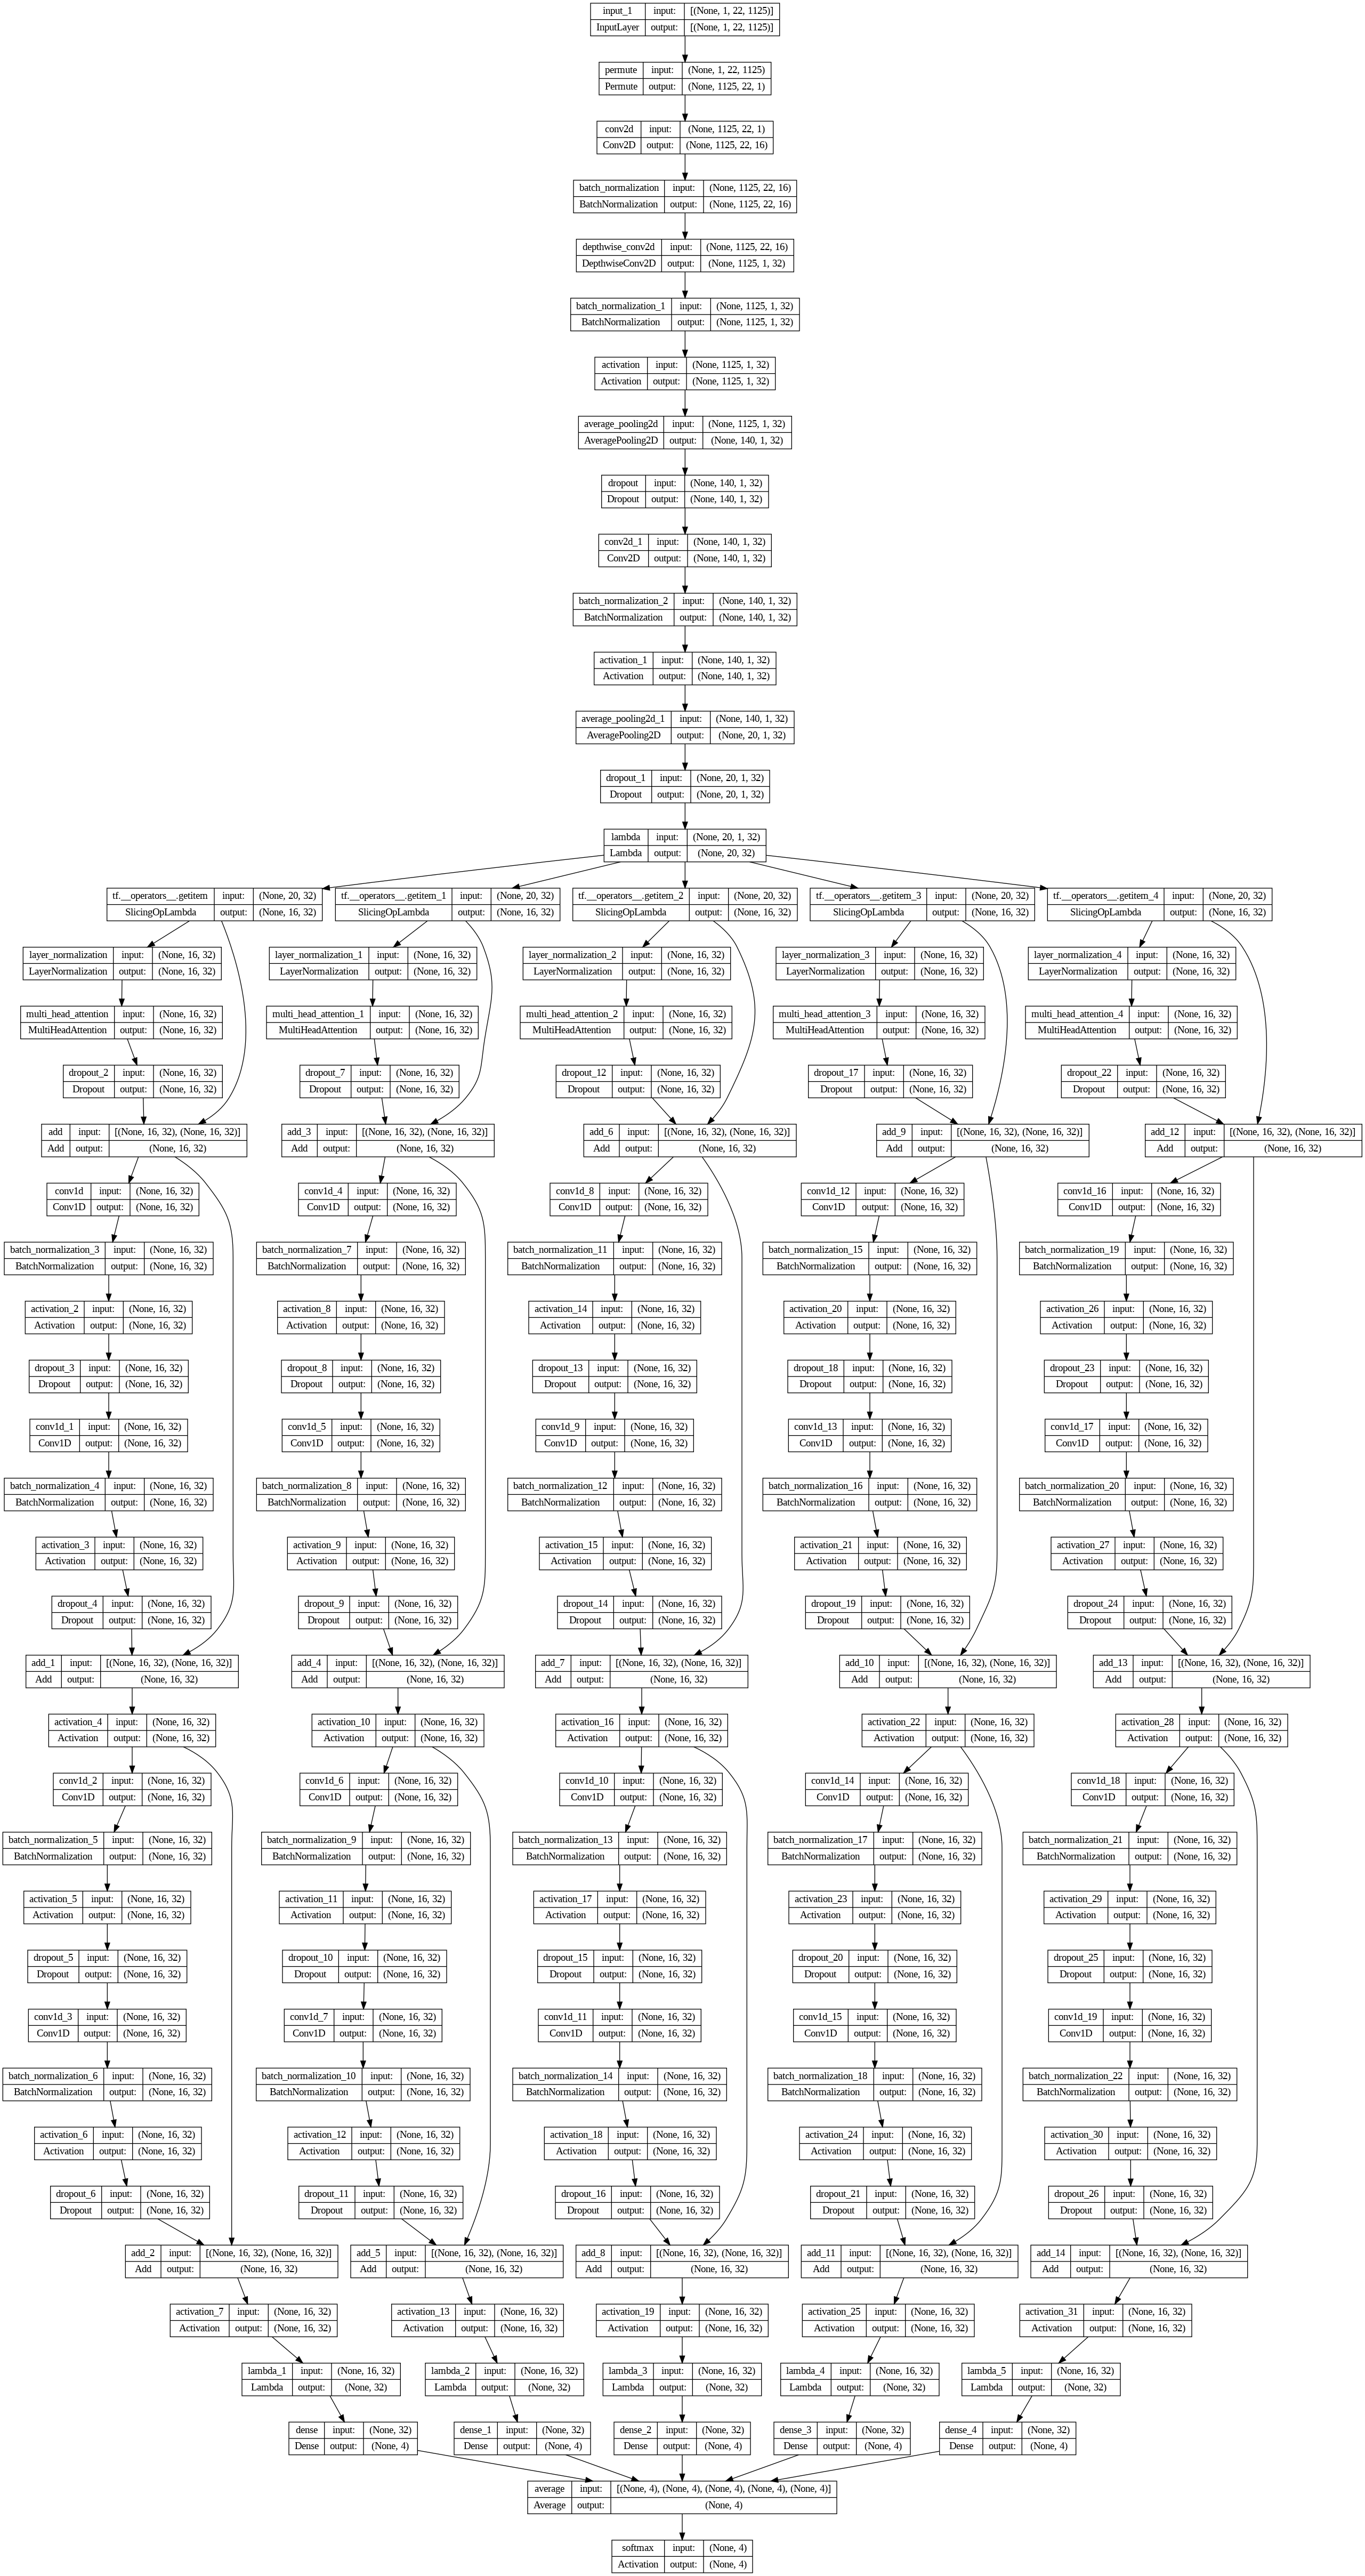

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

Training

In [ ]:
train_conf.get('model')

'ATCNet'


ATCNet Training

Training on subject  1
2/2 [==============================] - 2s 195ms/step
Subject: 1   seed 1   time: 4.7 m   valid_acc: 0.8966   valid_loss: 0.539
Plot Learning Curves ....... 


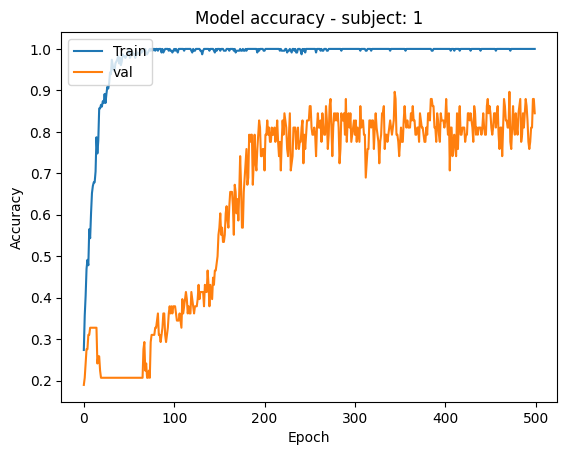

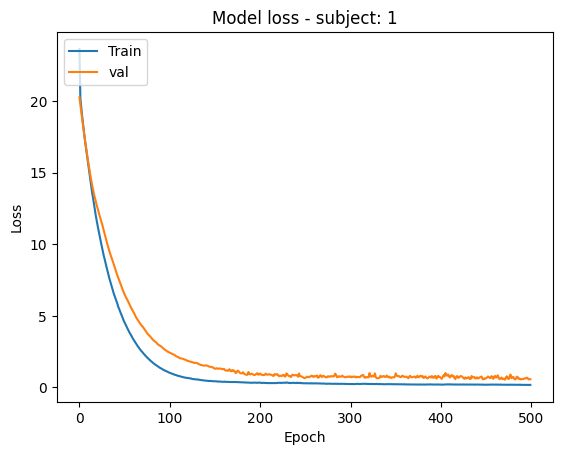


Training on subject  2
2/2 [==============================] - 1s 12ms/step
Subject: 2   seed 1   time: 3.7 m   valid_acc: 0.8276   valid_loss: 0.699
Plot Learning Curves ....... 


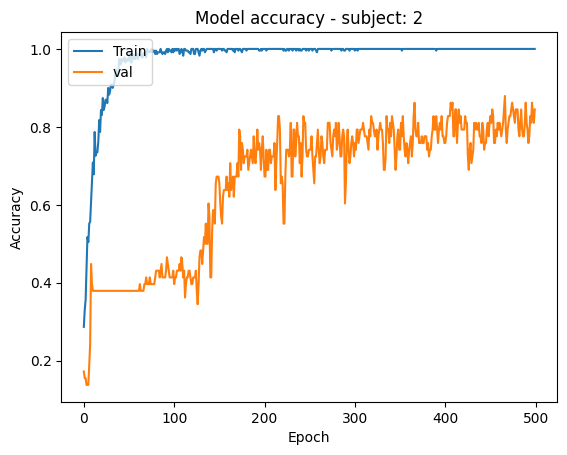

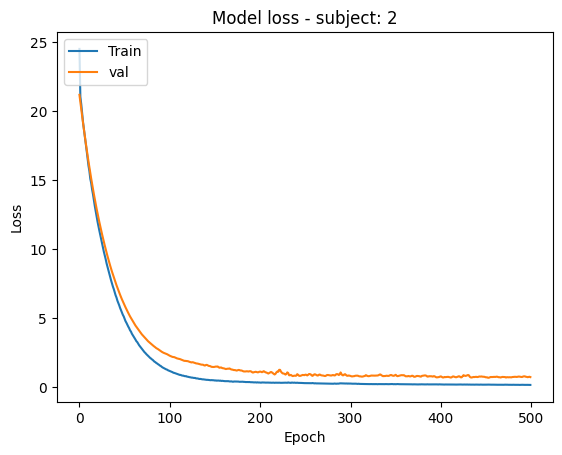


Training on subject  3
2/2 [==============================] - 1s 14ms/step
Subject: 3   seed 1   time: 3.7 m   valid_acc: 0.9138   valid_loss: 0.459
Plot Learning Curves ....... 


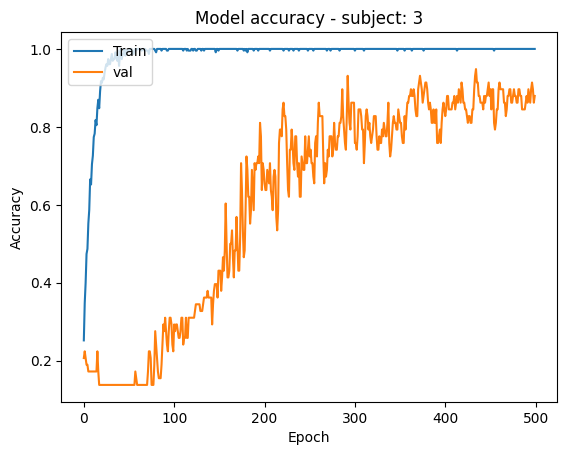

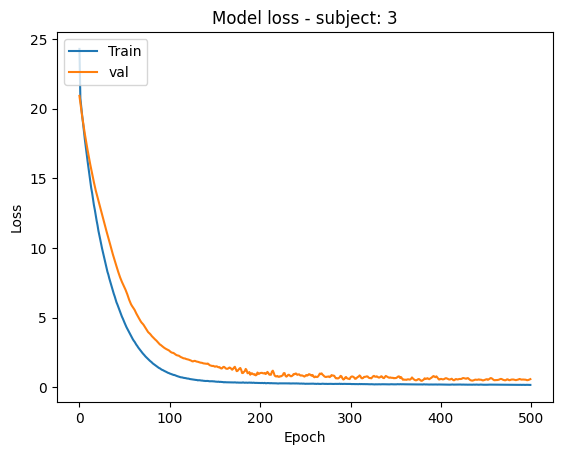


Training on subject  4
2/2 [==============================] - 1s 13ms/step
Subject: 4   seed 1   time: 3.7 m   valid_acc: 0.8276   valid_loss: 0.719
Plot Learning Curves ....... 


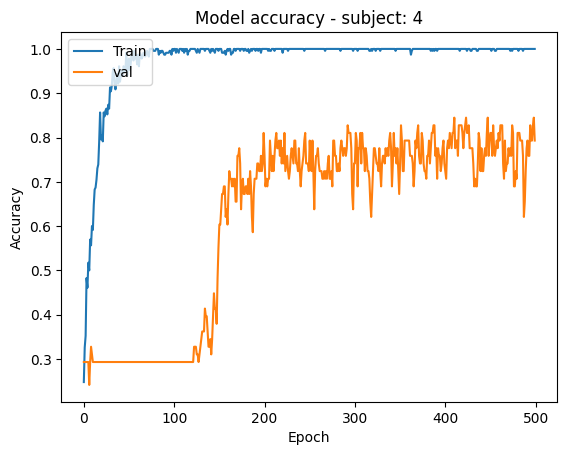

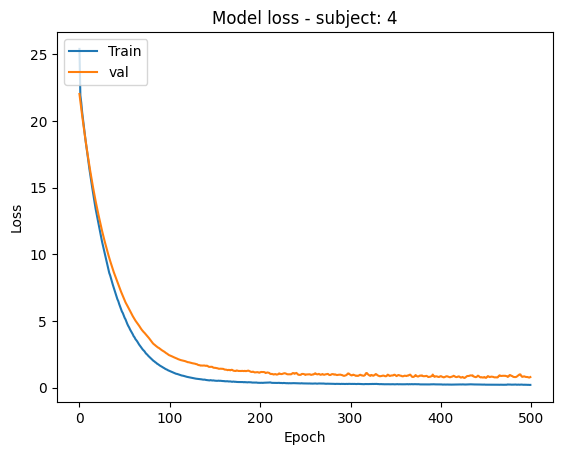


Training on subject  5


2/2 [==============================] - 1s 15ms/step
Subject: 5   seed 1   time: 3.8 m   valid_acc: 0.8621   valid_loss: 0.625
Plot Learning Curves ....... 


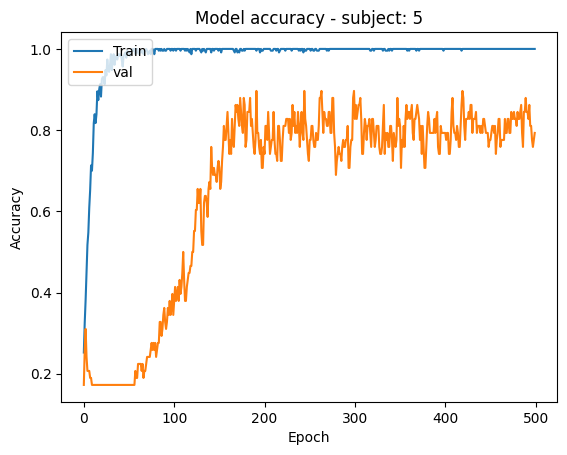

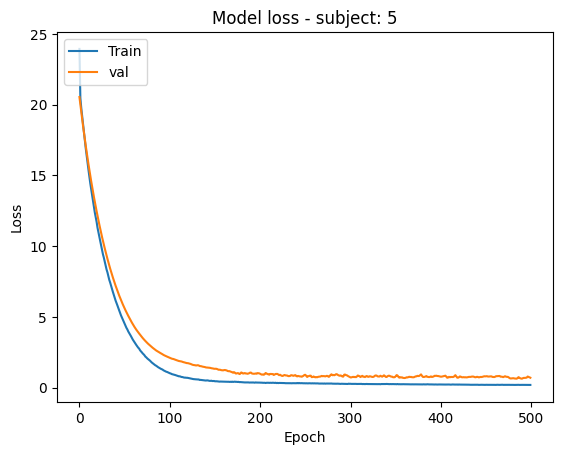


Training on subject  6


2/2 [==============================] - 1s 15ms/step
Subject: 6   seed 1   time: 3.6 m   valid_acc: 0.7931   valid_loss: 0.744
Plot Learning Curves ....... 


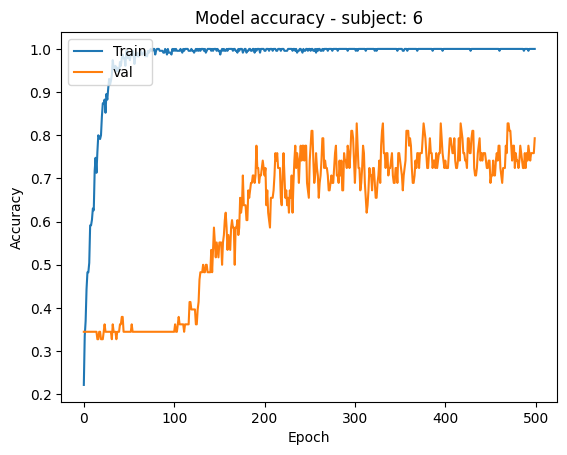

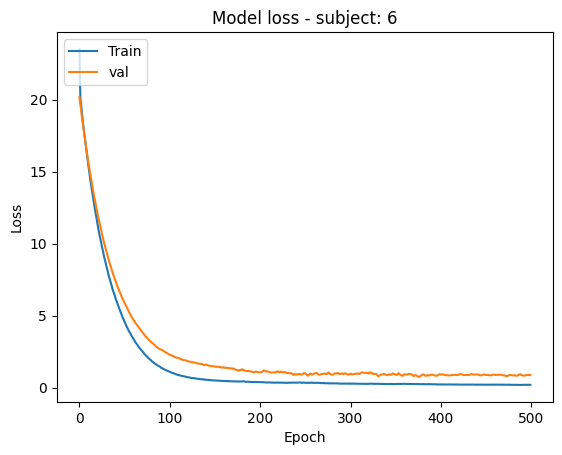


Training on subject  7
2/2 [==============================] - 2s 17ms/step
Subject: 7   seed 1   time: 3.8 m   valid_acc: 0.9655   valid_loss: 0.263
Plot Learning Curves ....... 


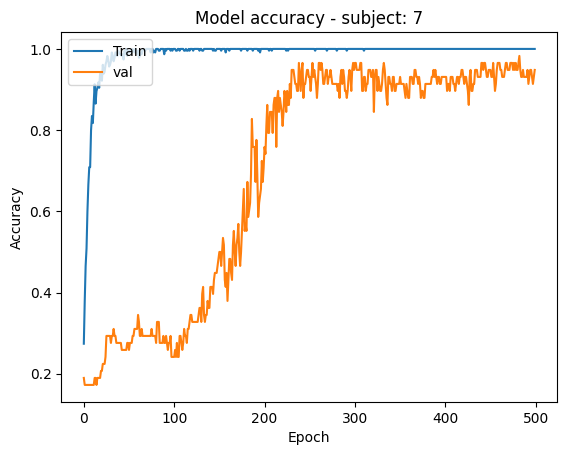

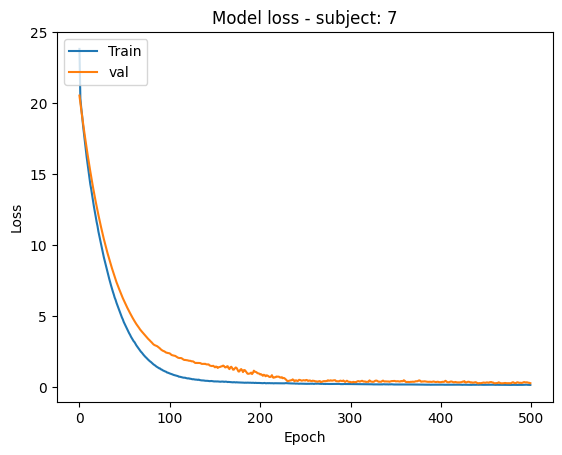


Training on subject  8
2/2 [==============================] - 1s 15ms/step
Subject: 8   seed 1   time: 3.5 m   valid_acc: 0.9138   valid_loss: 0.457
Plot Learning Curves ....... 


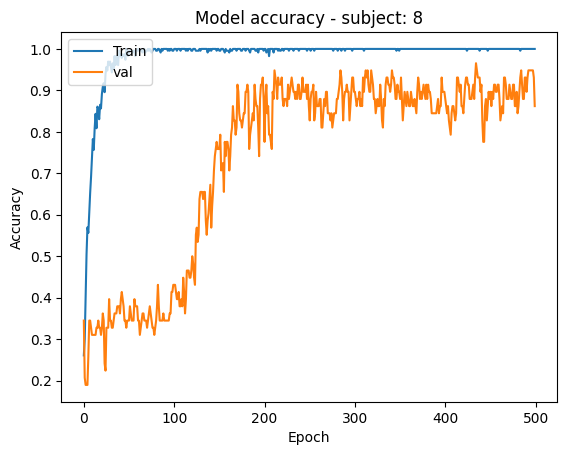

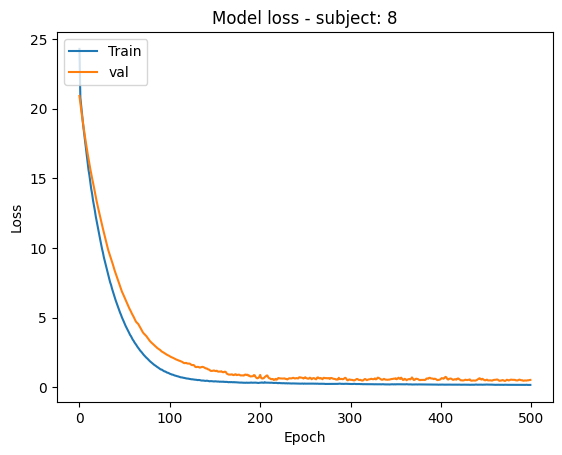


Training on subject  9
2/2 [==============================] - 1s 20ms/step
Subject: 9   seed 1   time: 3.7 m   valid_acc: 1.0000   valid_loss: 0.322
Plot Learning Curves ....... 


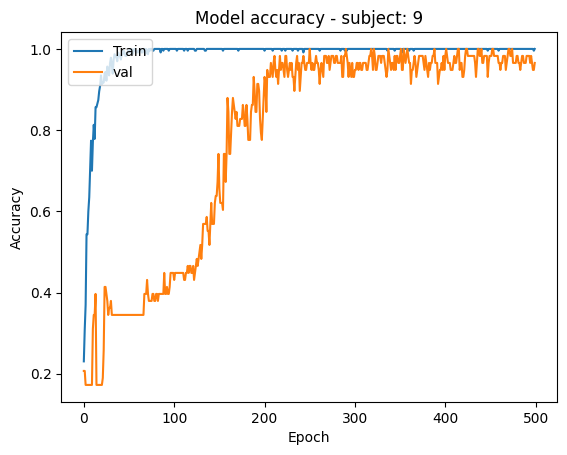

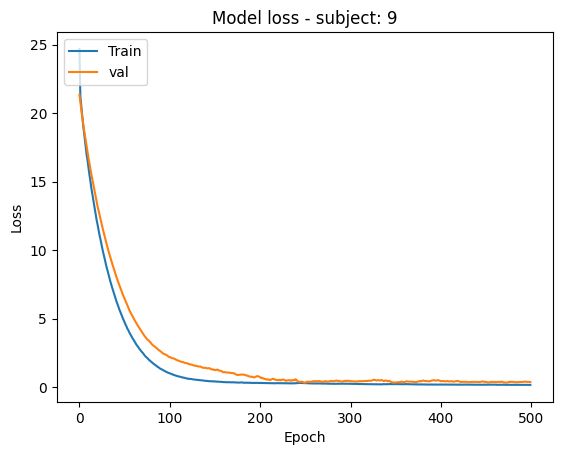


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  89.66   82.76   91.38   82.76   86.21   79.31   96.55   91.38   100.00     88.89   
---------------------------------
Average acc - all seeds: 88.89 %

Train Time  - all seeds: 34.5 min
---------------------------------



In [ ]:
train(dataset_conf, train_conf, results_path)

Testing

9/9 [==============================] - 0s 9ms/step

---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
                  -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1: (acc %)   86.81   59.72   92.71   79.86   69.10   70.83   94.79   81.94   87.15     80.32   
        (k-sco)   0.824   0.463   0.903   0.731   0.588   0.611   0.931   0.759   0.829     0.738   
----------------------------------
Average - all seeds (acc %): 80.32
                    (k-sco): 0.738

Inference time: 0.87 ms per trial
----------------------------------



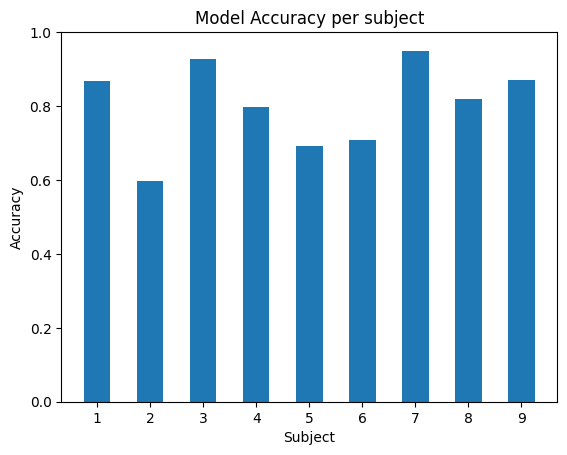

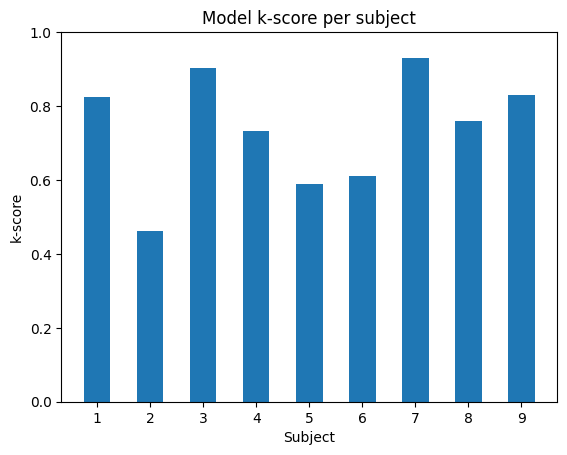

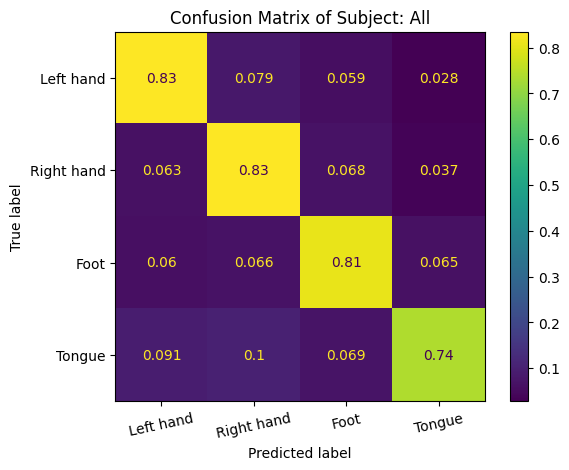

In [ ]:
model = getModel(train_conf.get('model'), dataset_conf)
test(model, dataset_conf, results_path)

# **EEGTCNet model**


EEGTCNet Training

Training on subject  1
2/2 [==============================] - 1s 235ms/step
Subject: 1   seed 1   time: 1.3 m   valid_acc: 0.7759   valid_loss: 0.645
Plot Learning Curves ....... 


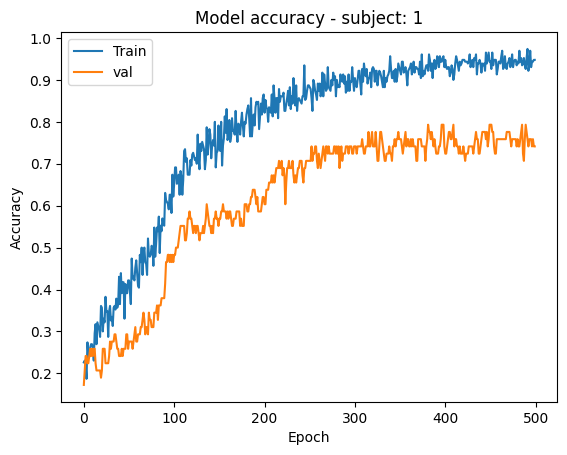

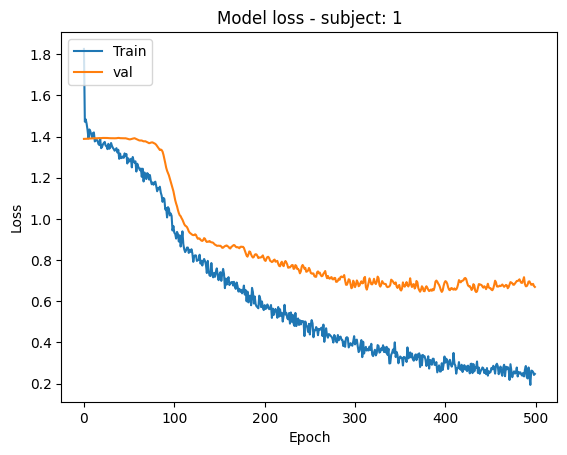


Training on subject  2
2/2 [==============================] - 0s 8ms/step
Subject: 2   seed 1   time: 1.4 m   valid_acc: 0.6034   valid_loss: 0.873
Plot Learning Curves ....... 


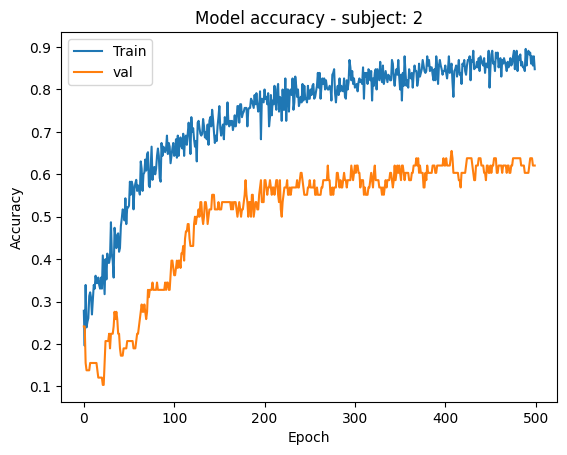

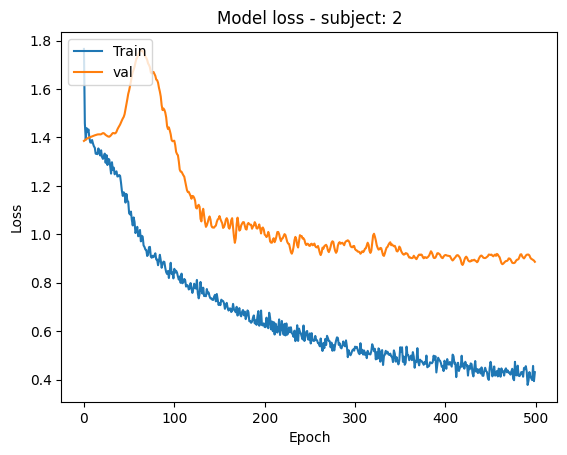


Training on subject  3
2/2 [==============================] - 0s 8ms/step
Subject: 3   seed 1   time: 1.4 m   valid_acc: 0.8103   valid_loss: 0.577
Plot Learning Curves ....... 


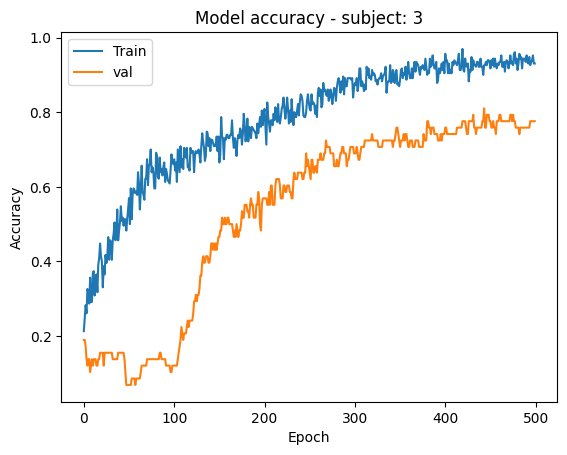

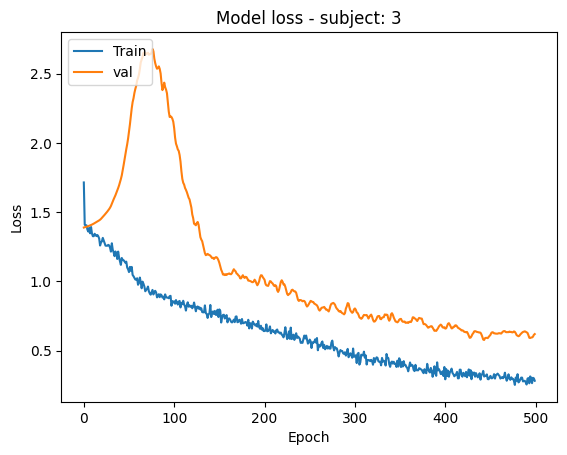


Training on subject  4
2/2 [==============================] - 0s 7ms/step
Subject: 4   seed 1   time: 1.4 m   valid_acc: 0.5862   valid_loss: 0.816
Plot Learning Curves ....... 


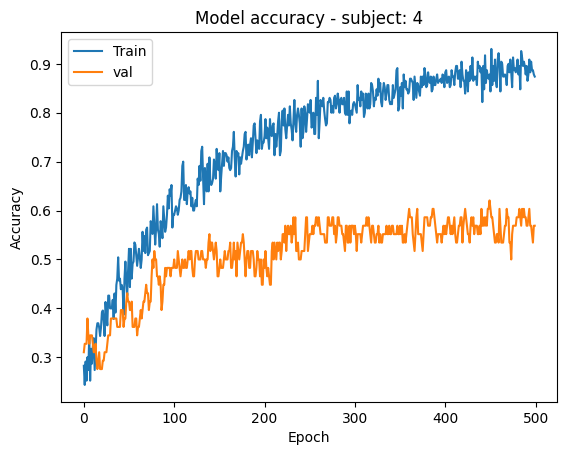

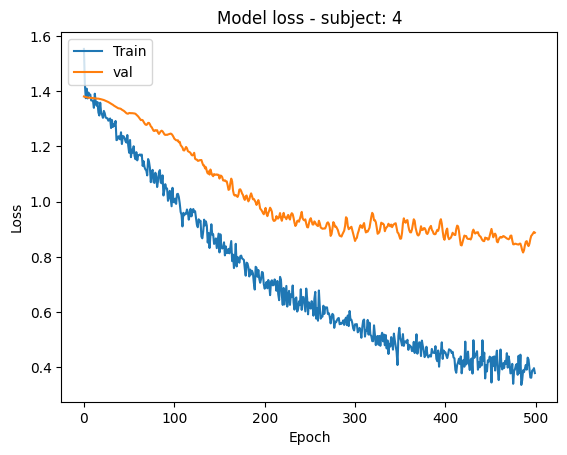


Training on subject  5
2/2 [==============================] - 0s 8ms/step
Subject: 5   seed 1   time: 1.2 m   valid_acc: 0.7414   valid_loss: 0.838
Plot Learning Curves ....... 


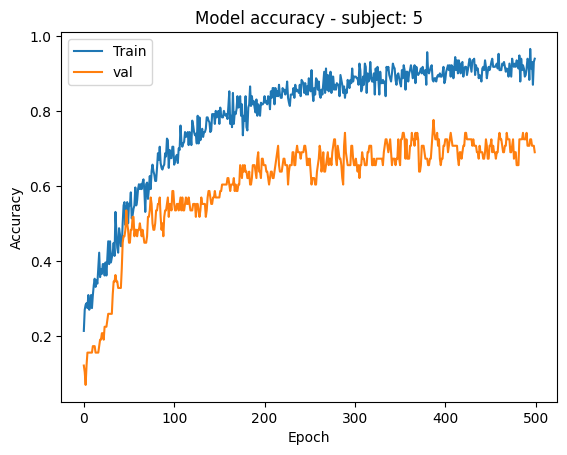

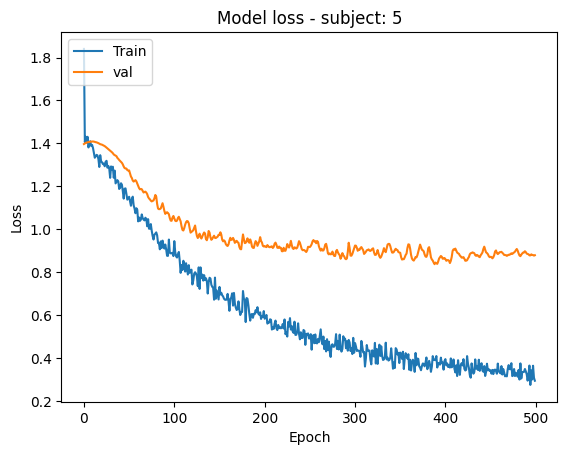


Training on subject  6
2/2 [==============================] - 0s 6ms/step
Subject: 6   seed 1   time: 1.5 m   valid_acc: 0.7069   valid_loss: 0.747
Plot Learning Curves ....... 


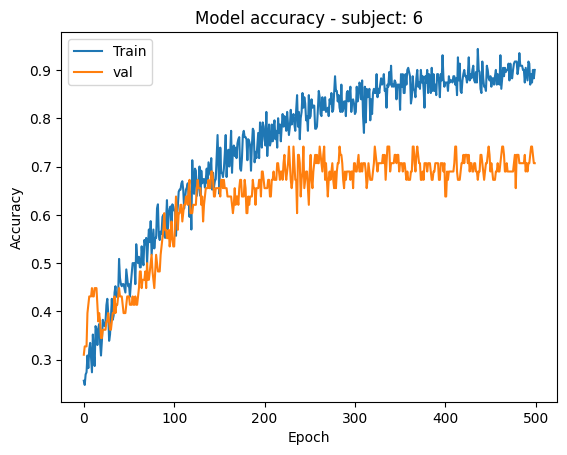

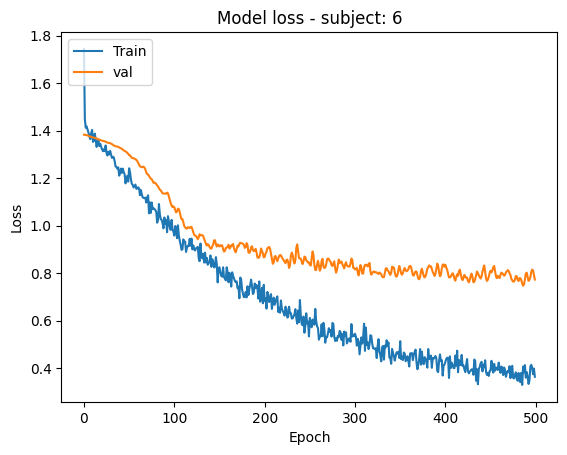


Training on subject  7
2/2 [==============================] - 0s 7ms/step
Subject: 7   seed 1   time: 1.4 m   valid_acc: 0.9138   valid_loss: 0.286
Plot Learning Curves ....... 


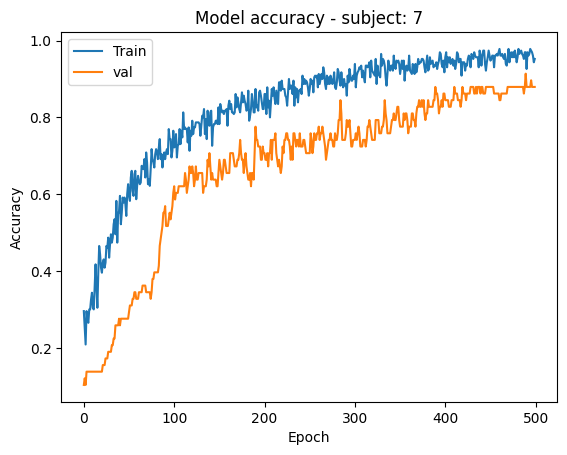

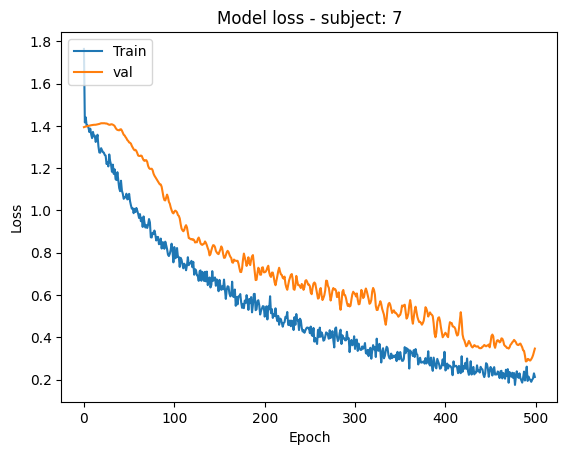


Training on subject  8
2/2 [==============================] - 0s 9ms/step
Subject: 8   seed 1   time: 1.4 m   valid_acc: 0.7759   valid_loss: 0.478
Plot Learning Curves ....... 


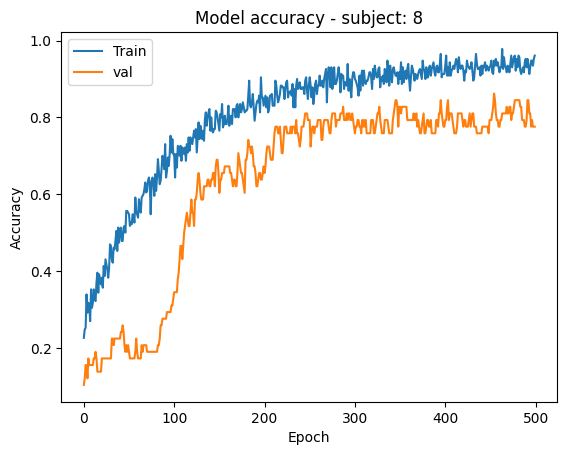

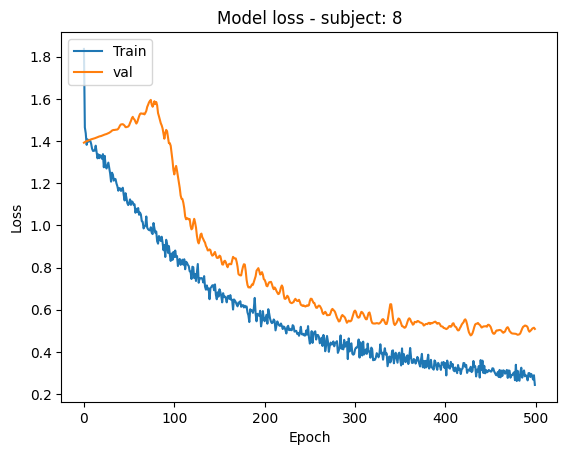


Training on subject  9
2/2 [==============================] - 0s 9ms/step
Subject: 9   seed 1   time: 1.3 m   valid_acc: 0.8448   valid_loss: 0.363
Plot Learning Curves ....... 


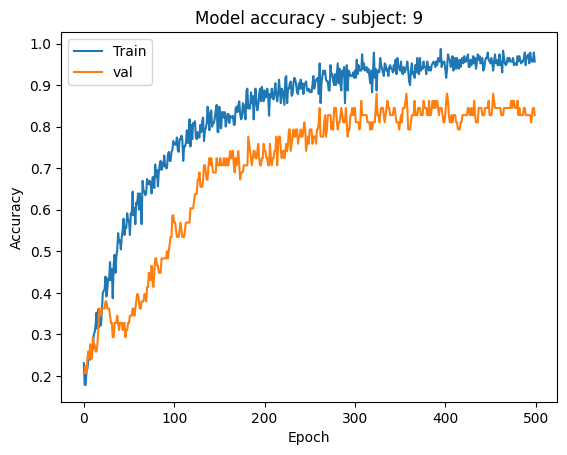

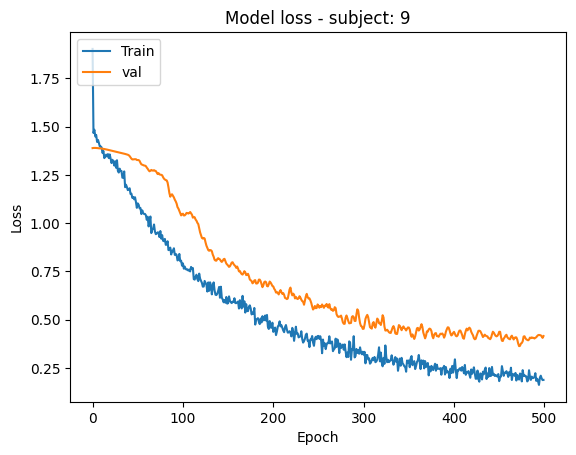


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  77.59   60.34   81.03   58.62   74.14   70.69   91.38   77.59   84.48     75.10   
---------------------------------
Average acc - all seeds: 75.10 %

Train Time  - all seeds: 12.8 min
---------------------------------

9/9 [==============================] - 0s 4ms/step

---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
                  -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1: (acc %)   76.39   48.61   85.07   58.33   62.15   52.78   73.61   75.35   66.67     66.55   
        (k-sco)   0.685   0.315  

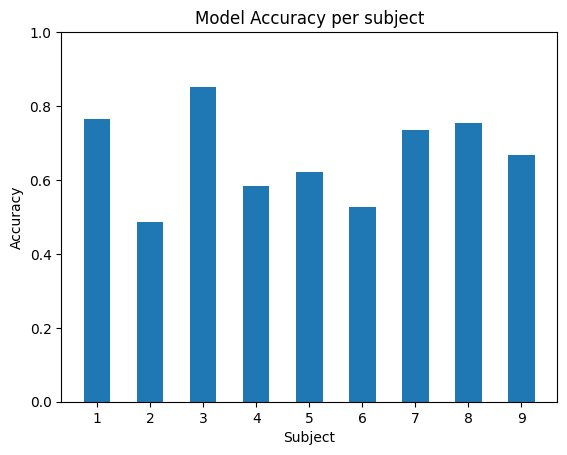

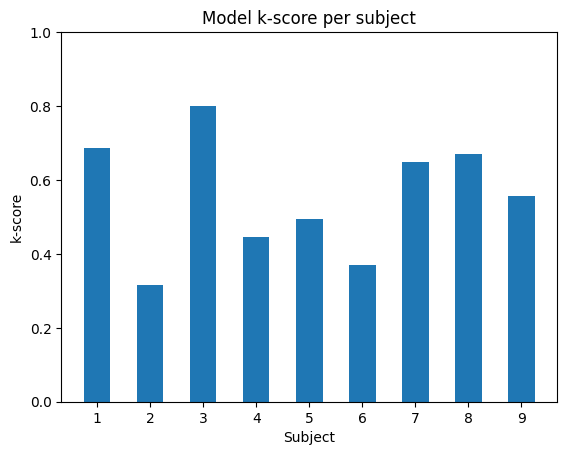

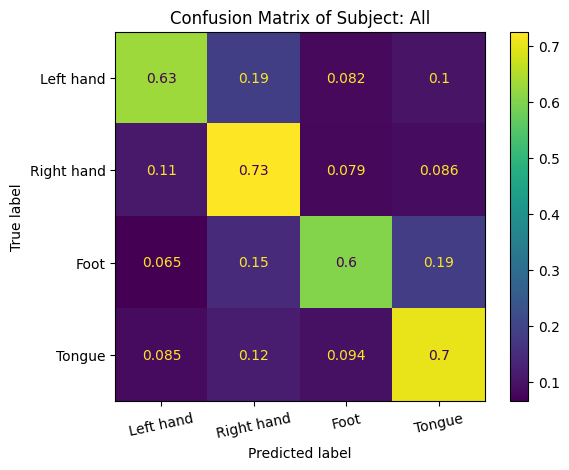

In [ ]:
train_conf['model']='EEGTCNet'
train(dataset_conf,train_conf,results_path)
model=getModel(train_conf.get('model'),dataset_conf)
test(model,dataset_conf,results_path)

# **EEGNet model**


EEGNet Training

Training on subject  1
2/2 [==============================] - 0s 34ms/step
Subject: 1   seed 1   time: 1.1 m   valid_acc: 0.7241   valid_loss: 0.690
Plot Learning Curves ....... 


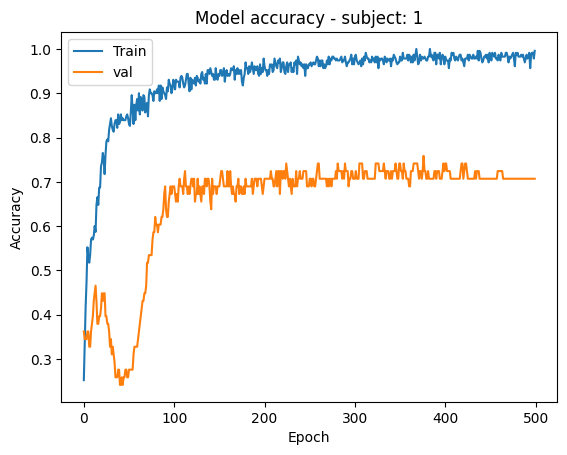

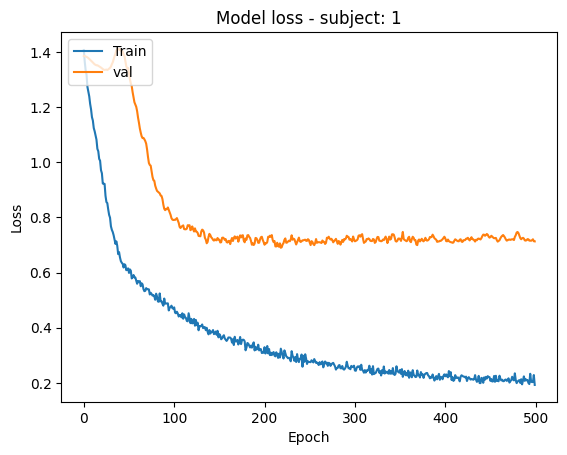


Training on subject  2
2/2 [==============================] - 0s 7ms/step
Subject: 2   seed 1   time: 1.1 m   valid_acc: 0.6379   valid_loss: 1.010
Plot Learning Curves ....... 


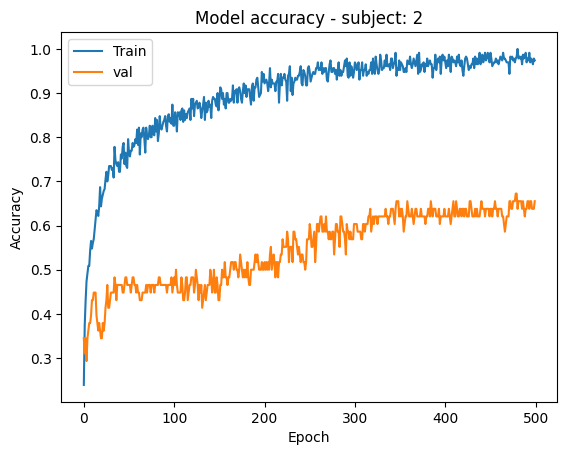

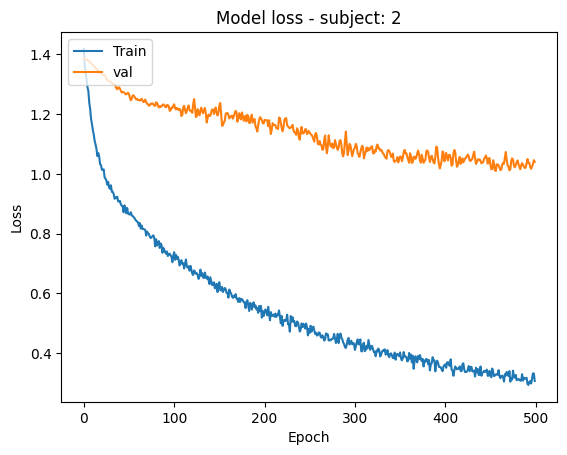


Training on subject  3
2/2 [==============================] - 0s 6ms/step
Subject: 3   seed 1   time: 1.1 m   valid_acc: 0.8276   valid_loss: 0.447
Plot Learning Curves ....... 


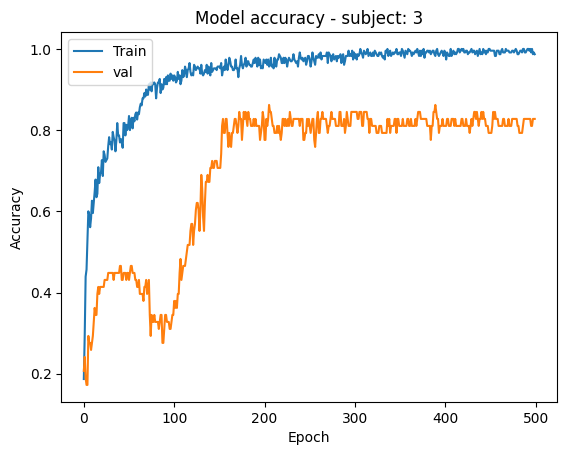

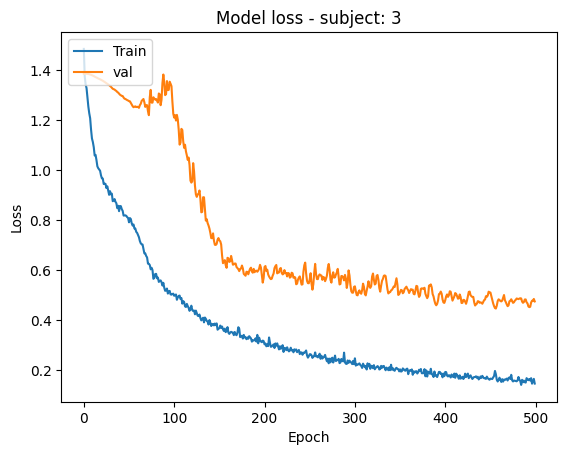


Training on subject  4
2/2 [==============================] - 0s 9ms/step
Subject: 4   seed 1   time: 1.1 m   valid_acc: 0.6552   valid_loss: 0.888
Plot Learning Curves ....... 


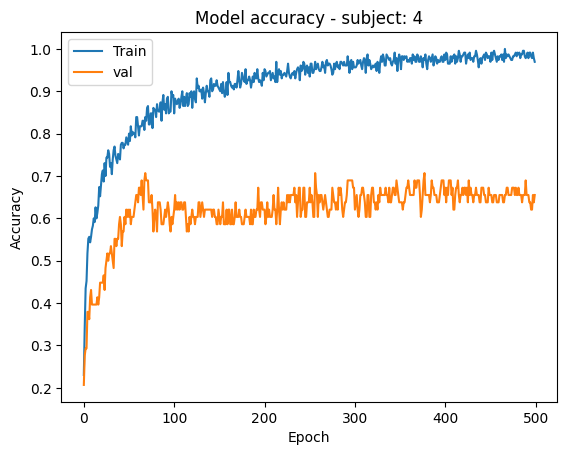

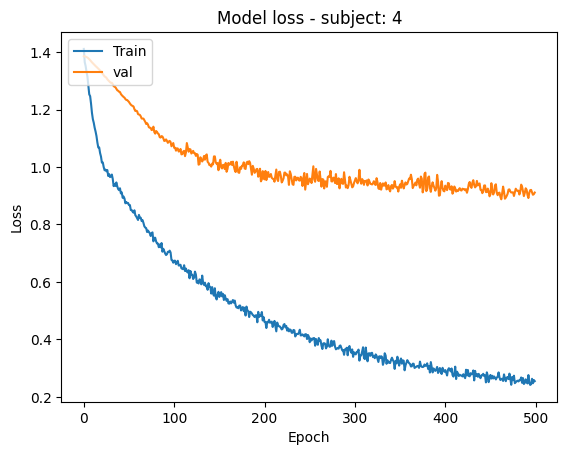


Training on subject  5
2/2 [==============================] - 0s 7ms/step
Subject: 5   seed 1   time: 1.4 m   valid_acc: 0.8103   valid_loss: 0.519
Plot Learning Curves ....... 


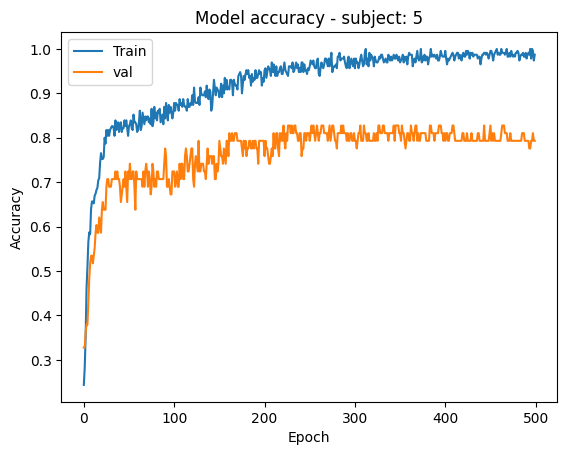

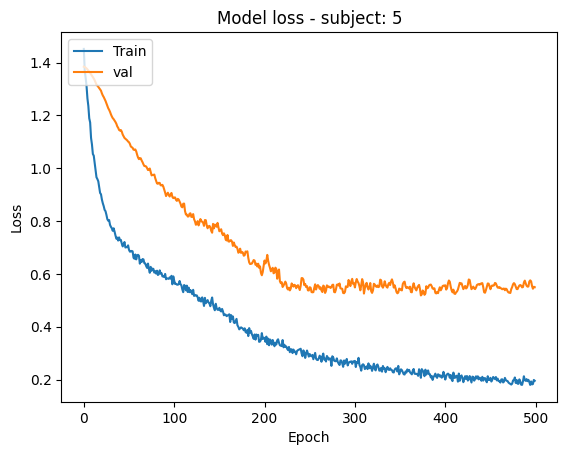


Training on subject  6
2/2 [==============================] - 0s 7ms/step
Subject: 6   seed 1   time: 1.1 m   valid_acc: 0.7414   valid_loss: 0.757
Plot Learning Curves ....... 


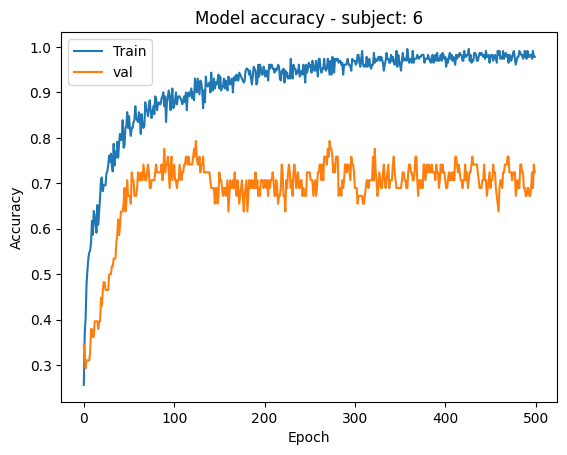

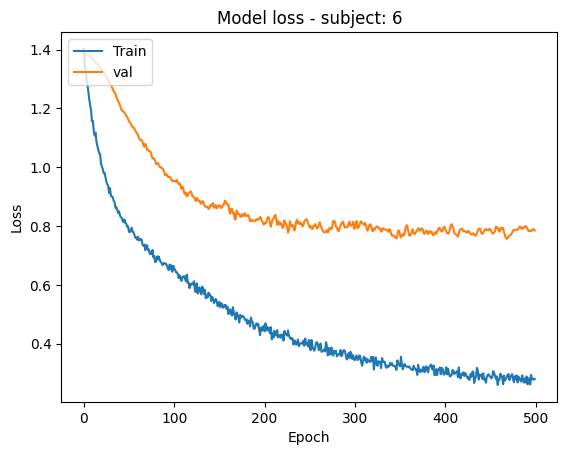


Training on subject  7
2/2 [==============================] - 0s 5ms/step
Subject: 7   seed 1   time: 1.1 m   valid_acc: 0.9138   valid_loss: 0.260
Plot Learning Curves ....... 


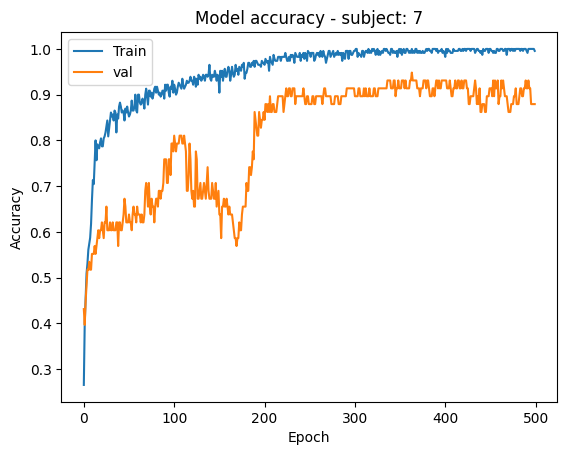

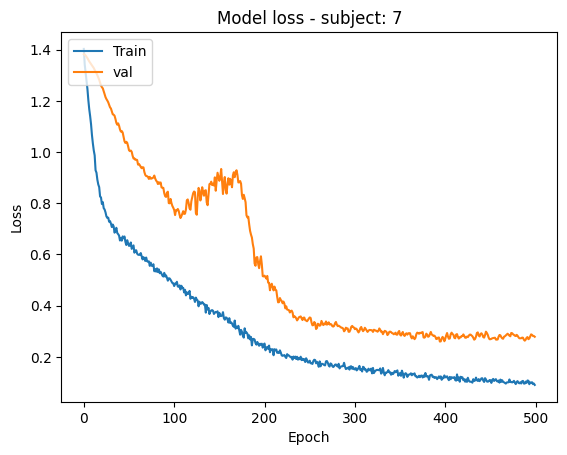


Training on subject  8
2/2 [==============================] - 0s 7ms/step
Subject: 8   seed 1   time: 1.1 m   valid_acc: 0.8103   valid_loss: 0.419
Plot Learning Curves ....... 


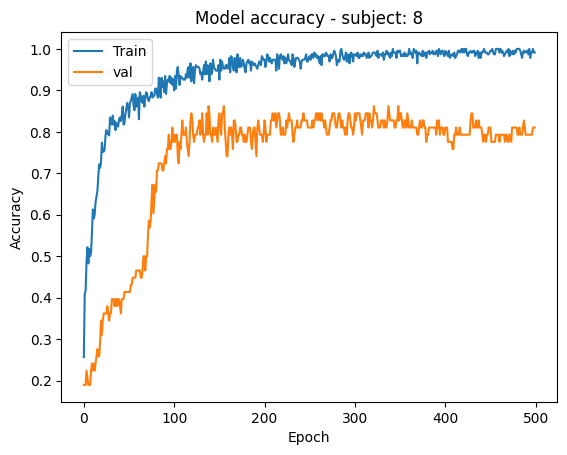

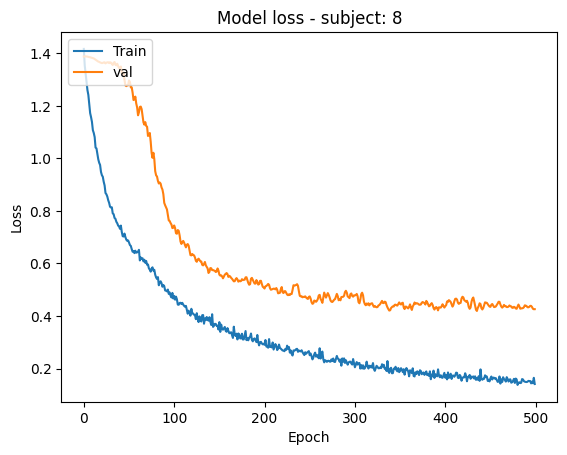


Training on subject  9
2/2 [==============================] - 0s 6ms/step
Subject: 9   seed 1   time: 1.4 m   valid_acc: 0.8621   valid_loss: 0.343
Plot Learning Curves ....... 


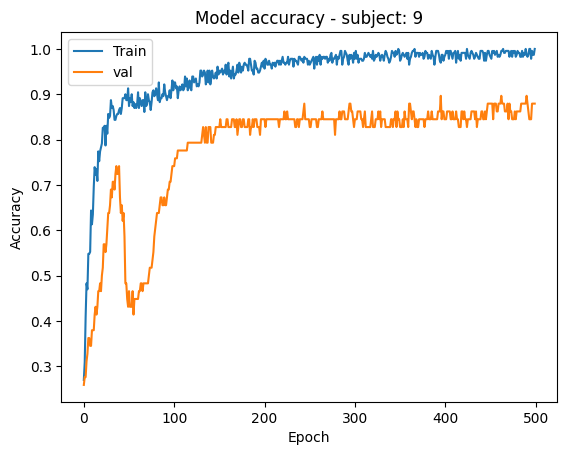

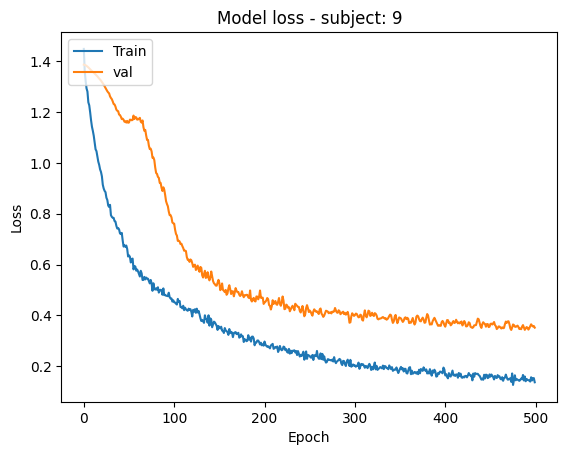


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  72.41   63.79   82.76   65.52   81.03   74.14   91.38   81.03   86.21     77.59   
---------------------------------
Average acc - all seeds: 77.59 %

Train Time  - all seeds: 10.7 min
---------------------------------

9/9 [==============================] - 0s 5ms/step

---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
                  -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1: (acc %)   78.47   48.61   87.85   59.03   44.10   53.82   76.74   79.51   66.32     66.05   
        (k-sco)   0.713   0.315  

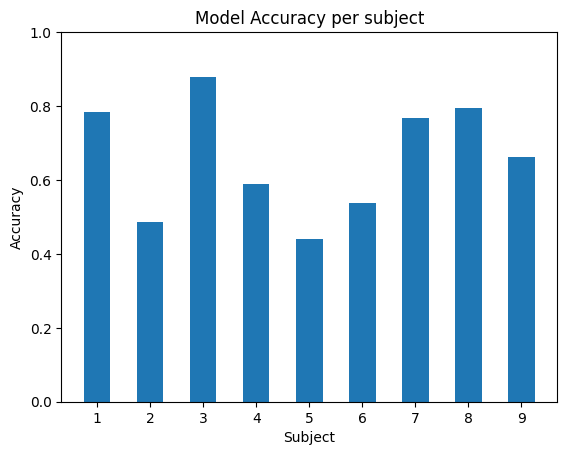

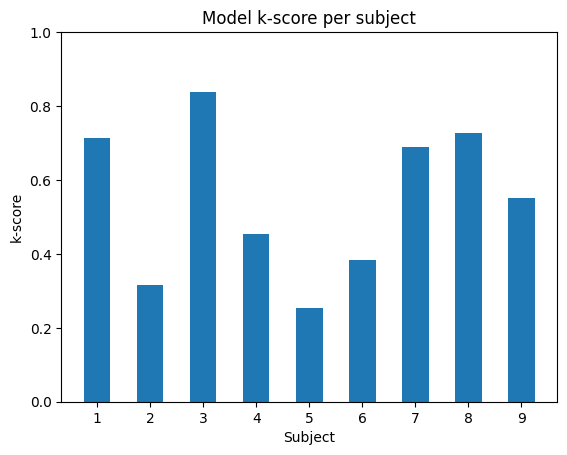

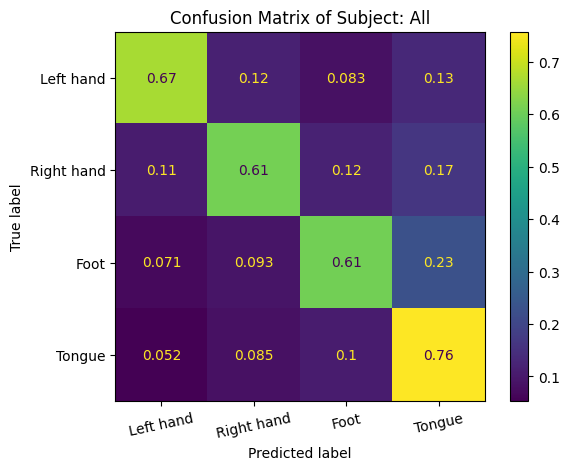

In [ ]:
train_conf['model']='EEGNet'
train(dataset_conf,train_conf,results_path)
model=getModel(train_conf.get('model'),dataset_conf)
test(model,dataset_conf,results_path)

# **DeepConvNet model**


DeepConvNet Training

Training on subject  1
2/2 [==============================] - 1s 278ms/step
Subject: 1   seed 1   time: 2.0 m   valid_acc: 0.5000   valid_loss: 1.251
Plot Learning Curves ....... 


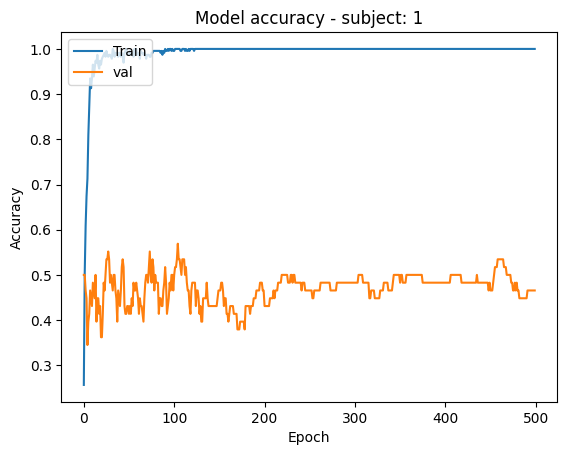

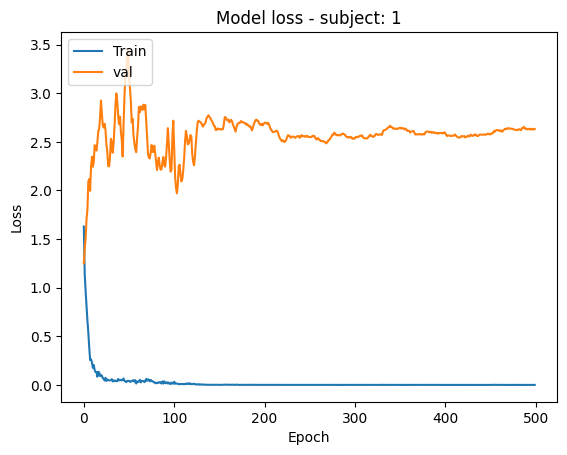


Training on subject  2
2/2 [==============================] - 0s 8ms/step
Subject: 2   seed 1   time: 2.4 m   valid_acc: 0.4483   valid_loss: 1.201
Plot Learning Curves ....... 


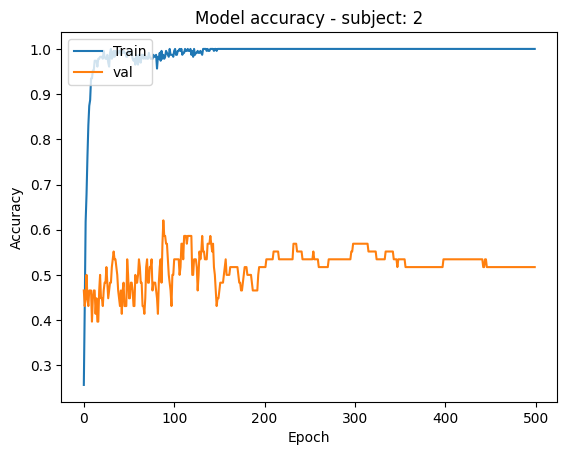

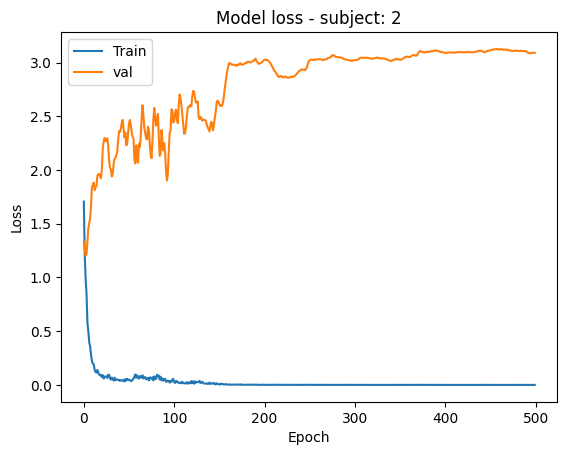


Training on subject  3
2/2 [==============================] - 0s 13ms/step
Subject: 3   seed 1   time: 1.8 m   valid_acc: 0.2414   valid_loss: 1.405
Plot Learning Curves ....... 


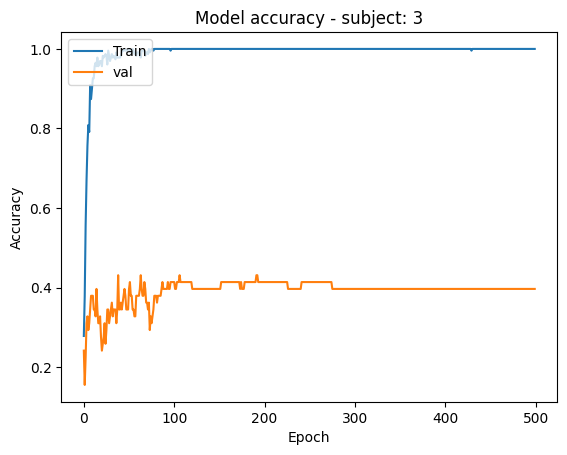

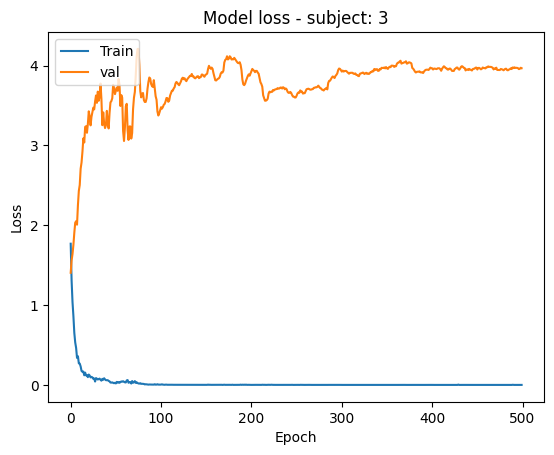


Training on subject  4
2/2 [==============================] - 0s 12ms/step
Subject: 4   seed 1   time: 1.8 m   valid_acc: 0.3276   valid_loss: 1.364
Plot Learning Curves ....... 


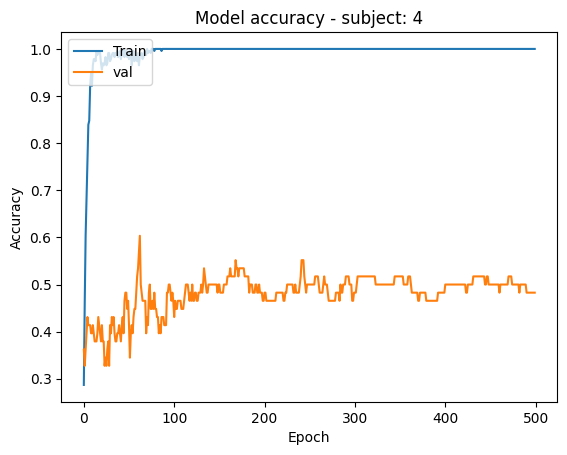

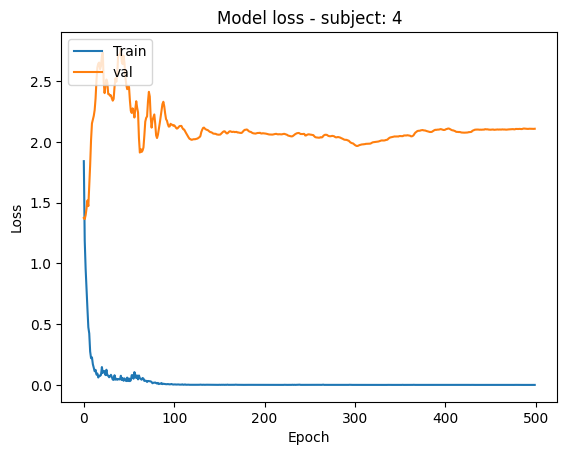


Training on subject  5
2/2 [==============================] - 0s 8ms/step
Subject: 5   seed 1   time: 2.4 m   valid_acc: 0.6034   valid_loss: 0.905
Plot Learning Curves ....... 


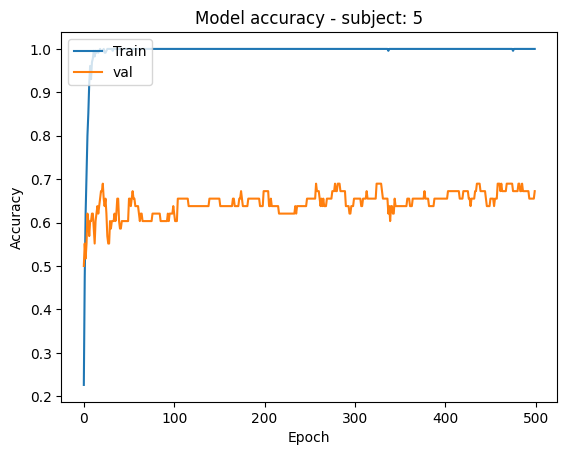

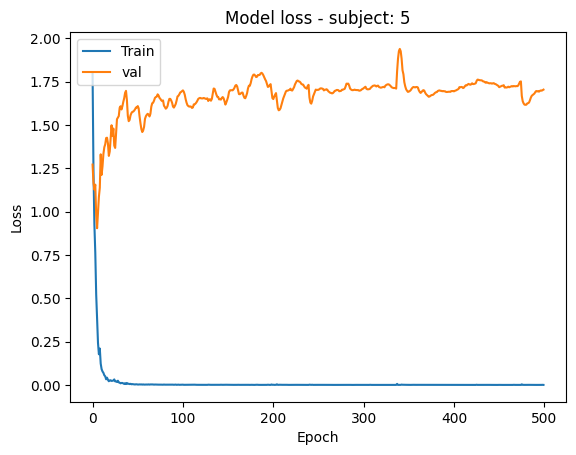


Training on subject  6
2/2 [==============================] - 0s 9ms/step
Subject: 6   seed 1   time: 2.4 m   valid_acc: 0.2414   valid_loss: 1.371
Plot Learning Curves ....... 


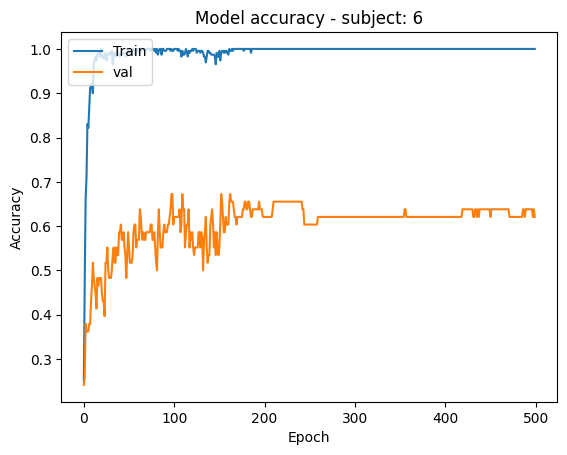

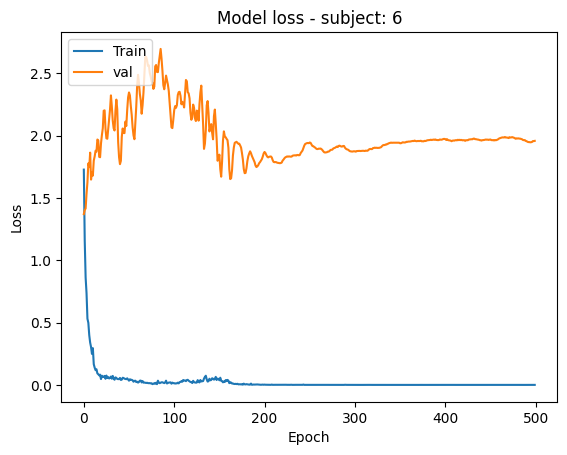


Training on subject  7
2/2 [==============================] - 0s 9ms/step
Subject: 7   seed 1   time: 2.4 m   valid_acc: 0.6724   valid_loss: 1.089
Plot Learning Curves ....... 


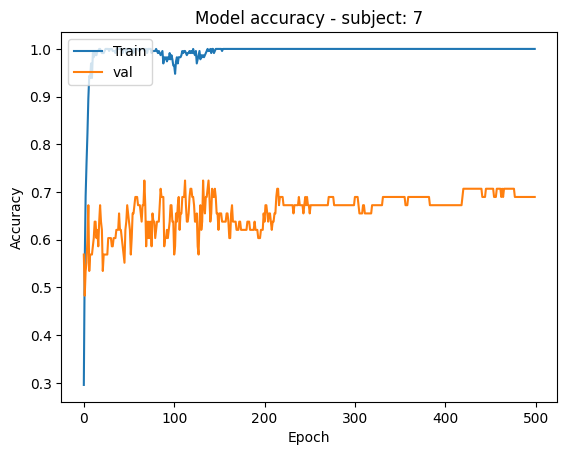

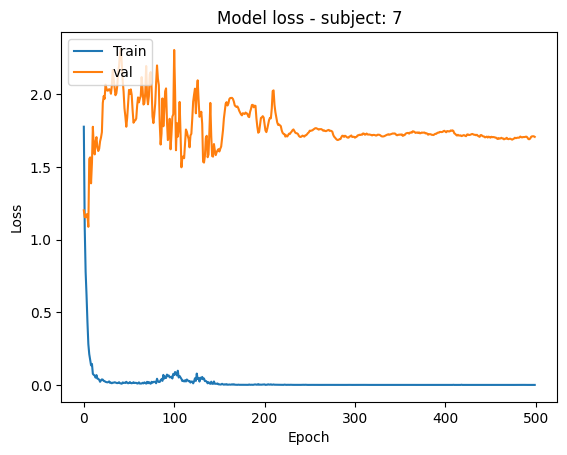


Training on subject  8
2/2 [==============================] - 0s 8ms/step
Subject: 8   seed 1   time: 1.7 m   valid_acc: 0.2414   valid_loss: 1.396
Plot Learning Curves ....... 


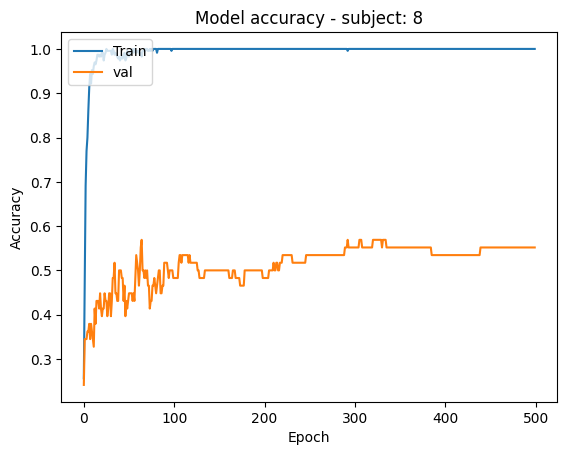

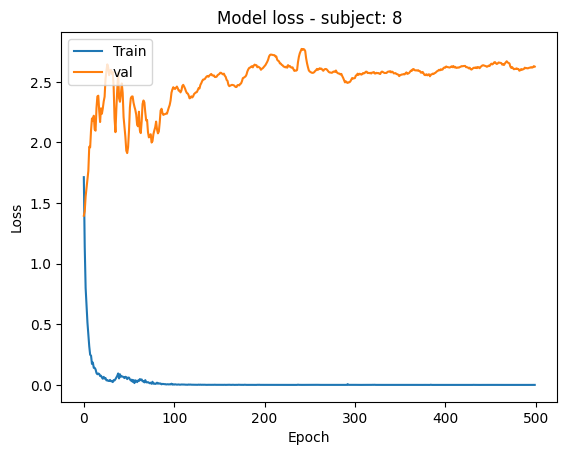


Training on subject  9
2/2 [==============================] - 0s 8ms/step
Subject: 9   seed 1   time: 1.7 m   valid_acc: 0.7759   valid_loss: 0.706
Plot Learning Curves ....... 


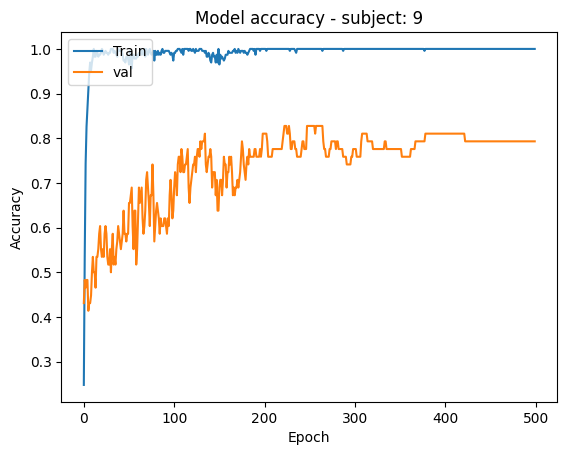

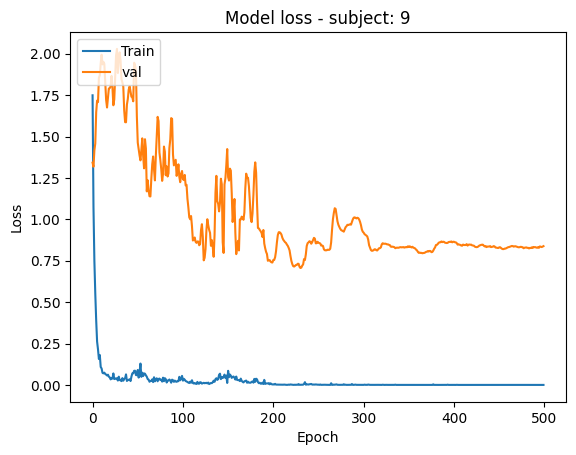


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  50.00   44.83   24.14   32.76   60.34   24.14   67.24   24.14   77.59     45.02   
---------------------------------
Average acc - all seeds: 45.02 %

Train Time  - all seeds: 19.0 min
---------------------------------

9/9 [==============================] - 0s 6ms/step

---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
                  -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1: (acc %)   39.58   31.94   26.74   36.11   53.82   34.38   52.78   31.60   60.76     40.86   
        (k-sco)   0.194   0.093  

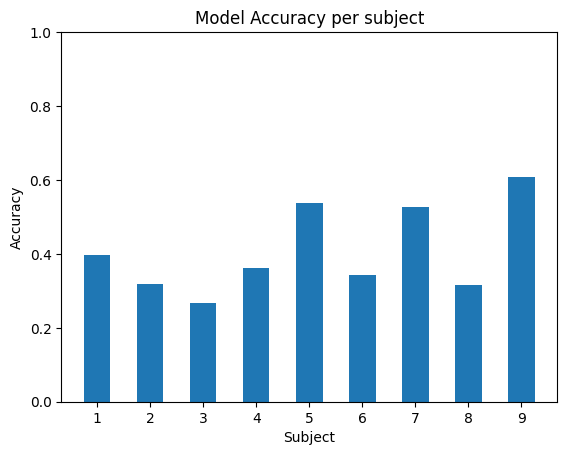

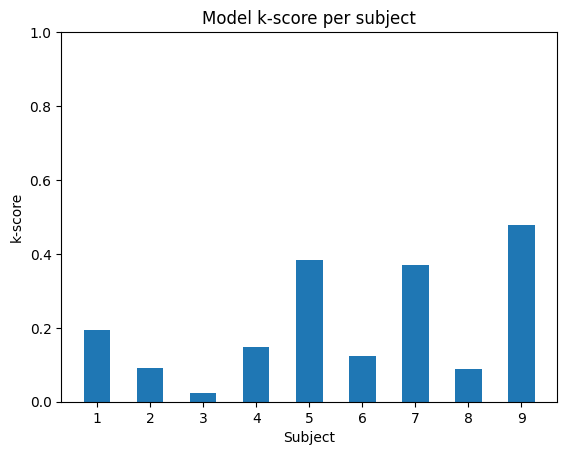

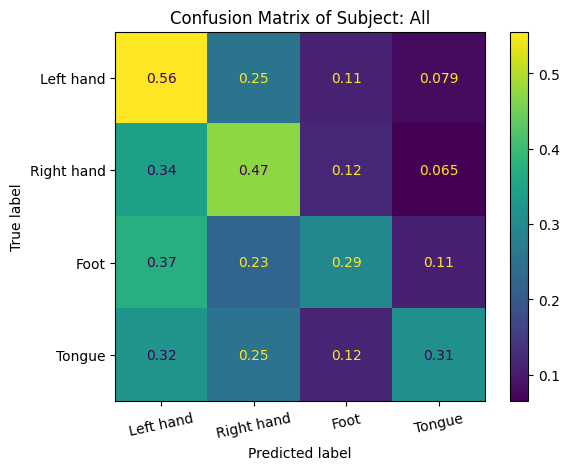

In [ ]:
train_conf['model']='DeepConvNet'
train(dataset_conf,train_conf,results_path)
model=getModel(train_conf.get('model'),dataset_conf)
test(model,dataset_conf,results_path)

# **ShallowConvNet model**


ShallowConvNet Training

Training on subject  1
2/2 [==============================] - 1s 257ms/step
Subject: 1   seed 1   time: 1.9 m   valid_acc: 0.7586   valid_loss: 0.616
Plot Learning Curves ....... 


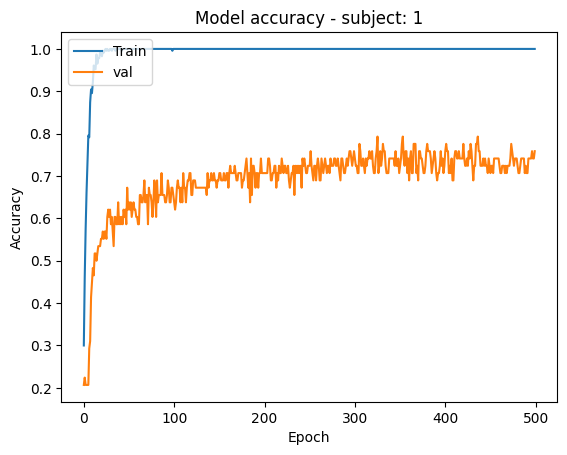

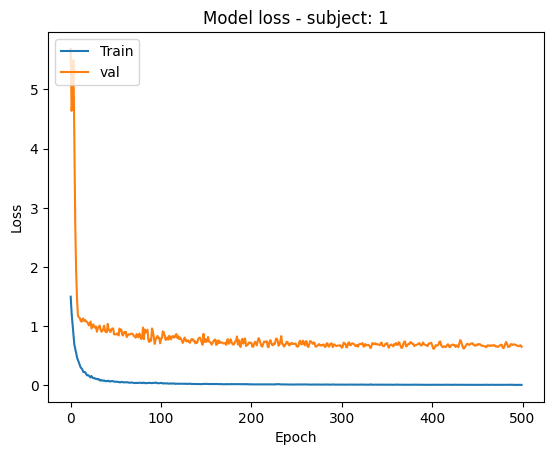


Training on subject  2
2/2 [==============================] - 0s 10ms/step
Subject: 2   seed 1   time: 2.4 m   valid_acc: 0.6379   valid_loss: 1.059
Plot Learning Curves ....... 


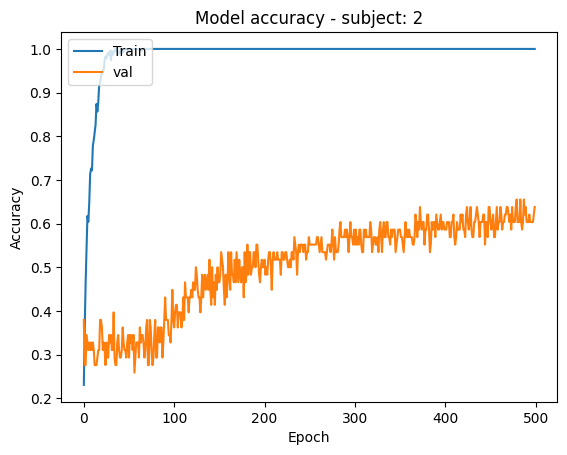

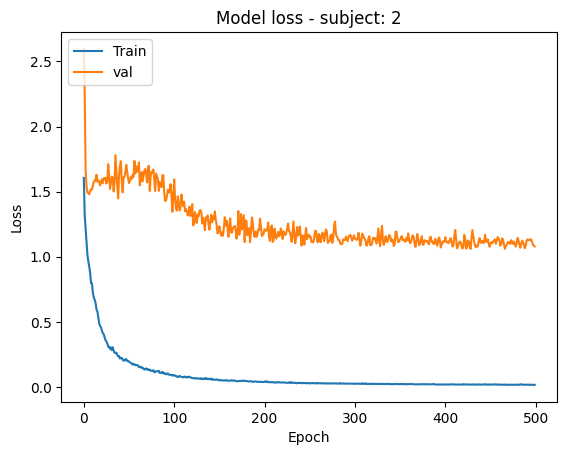


Training on subject  3
2/2 [==============================] - 0s 9ms/step
Subject: 3   seed 1   time: 2.4 m   valid_acc: 0.8621   valid_loss: 0.305
Plot Learning Curves ....... 


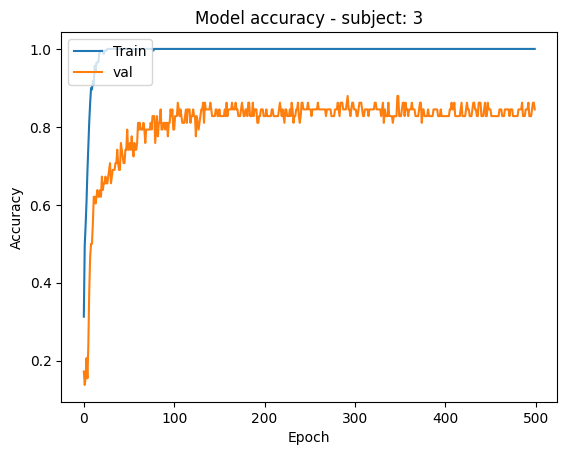

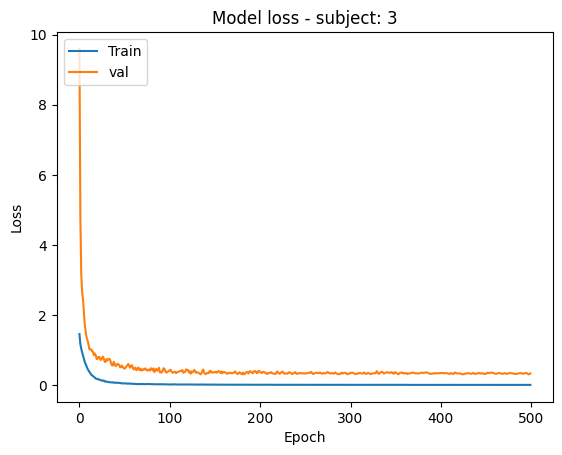


Training on subject  4
2/2 [==============================] - 0s 7ms/step
Subject: 4   seed 1   time: 1.8 m   valid_acc: 0.5345   valid_loss: 1.145
Plot Learning Curves ....... 


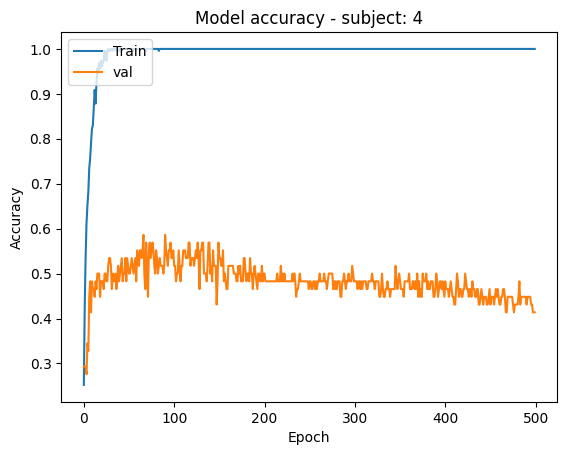

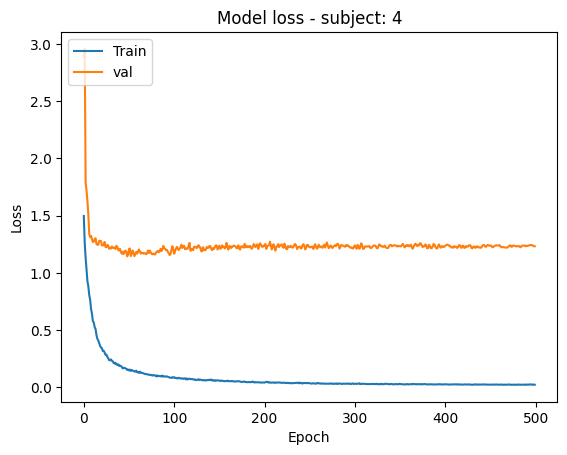


Training on subject  5
2/2 [==============================] - 0s 10ms/step
Subject: 5   seed 1   time: 2.4 m   valid_acc: 0.6379   valid_loss: 0.726
Plot Learning Curves ....... 


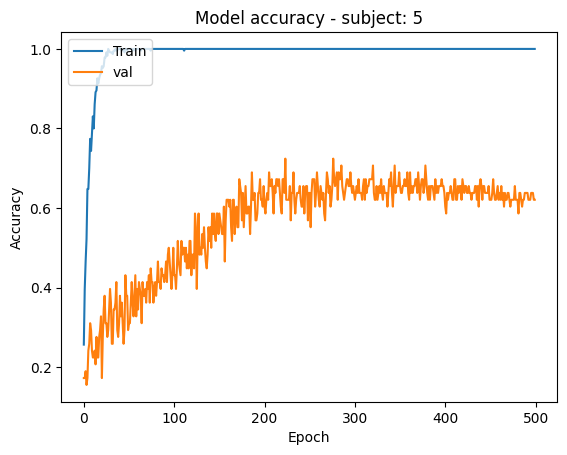

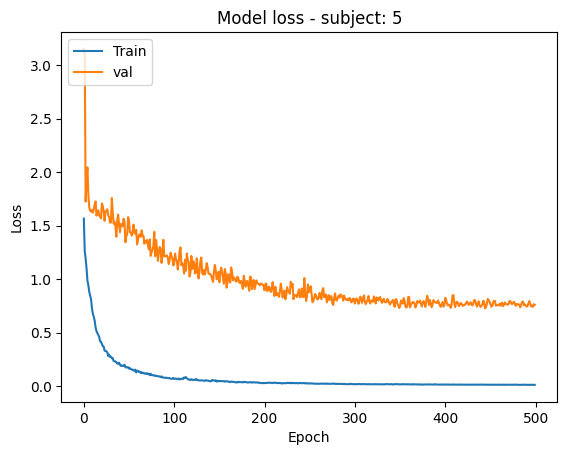


Training on subject  6
2/2 [==============================] - 0s 7ms/step
Subject: 6   seed 1   time: 1.8 m   valid_acc: 0.5345   valid_loss: 1.222
Plot Learning Curves ....... 


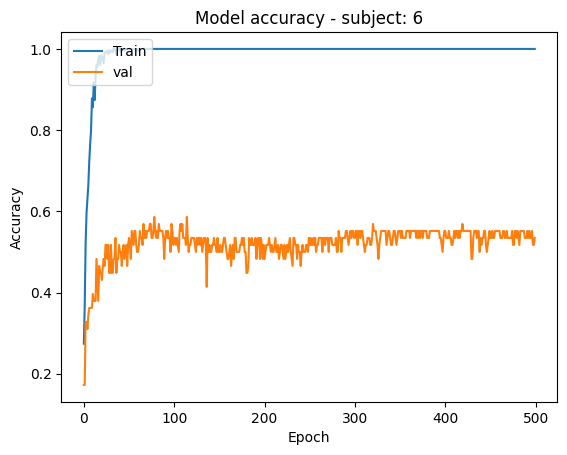

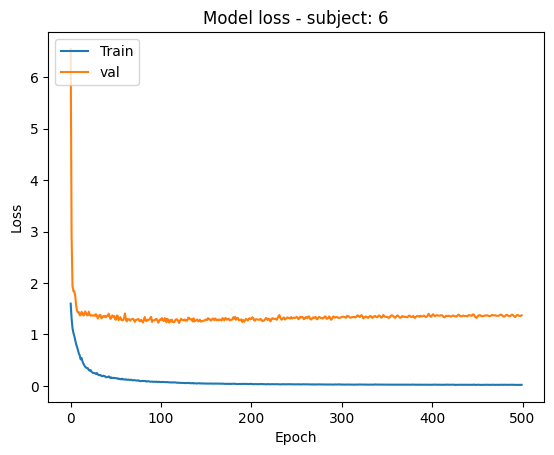


Training on subject  7
2/2 [==============================] - 0s 7ms/step
Subject: 7   seed 1   time: 1.8 m   valid_acc: 0.8276   valid_loss: 0.473
Plot Learning Curves ....... 


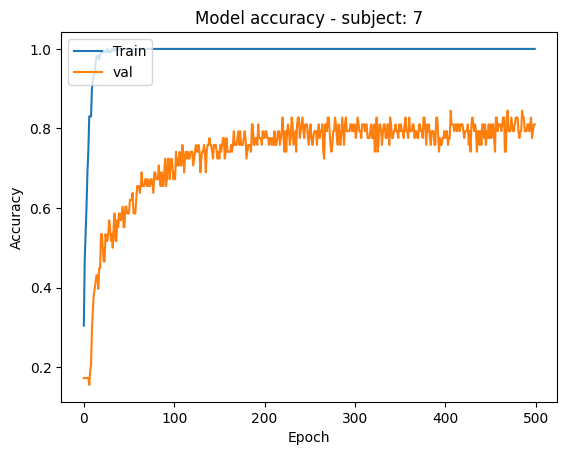

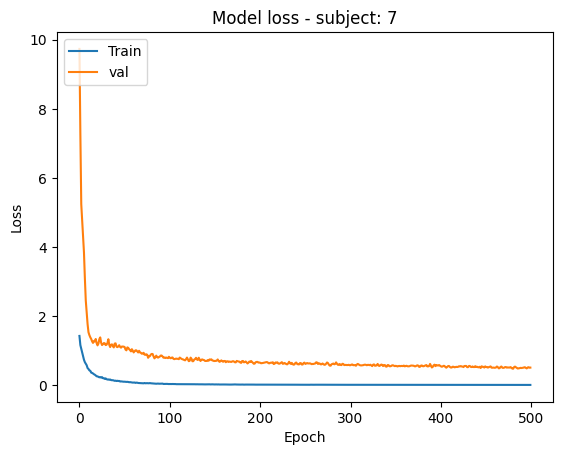


Training on subject  8
2/2 [==============================] - 0s 8ms/step
Subject: 8   seed 1   time: 2.4 m   valid_acc: 0.8448   valid_loss: 0.404
Plot Learning Curves ....... 


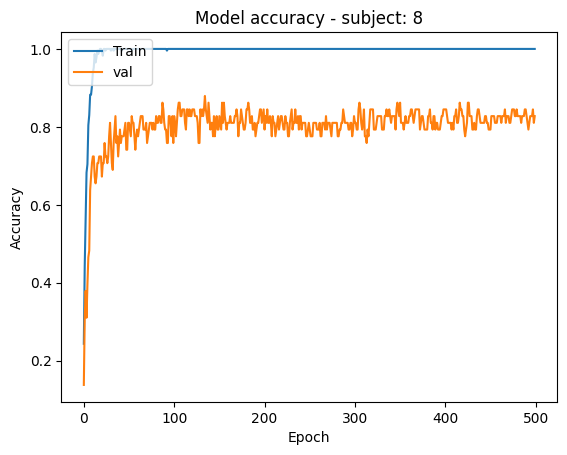

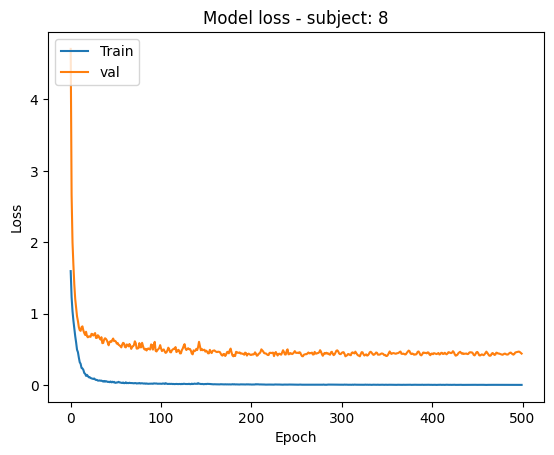


Training on subject  9
2/2 [==============================] - 0s 9ms/step
Subject: 9   seed 1   time: 2.4 m   valid_acc: 0.8621   valid_loss: 0.317
Plot Learning Curves ....... 


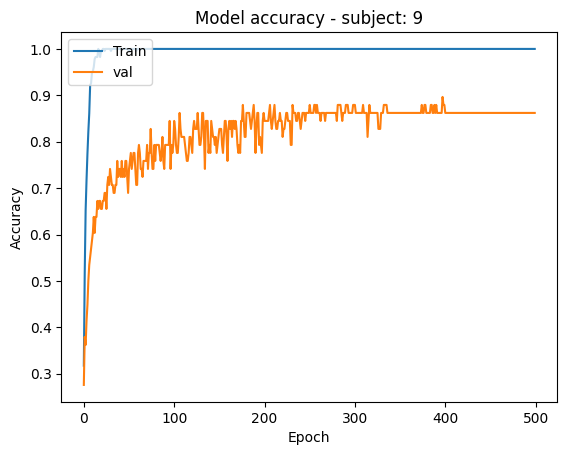

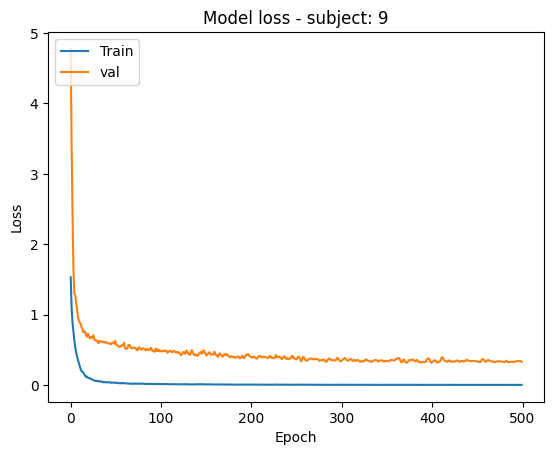


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  75.86   63.79   86.21   53.45   63.79   53.45   82.76   84.48   86.21     72.22   
---------------------------------
Average acc - all seeds: 72.22 %

Train Time  - all seeds: 19.5 min
---------------------------------

9/9 [==============================] - 0s 6ms/step

---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
                  -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1: (acc %)   73.26   50.35   85.07   41.67   61.46   42.36   79.17   76.74   75.00     65.01   
        (k-sco)   0.644   0.338  

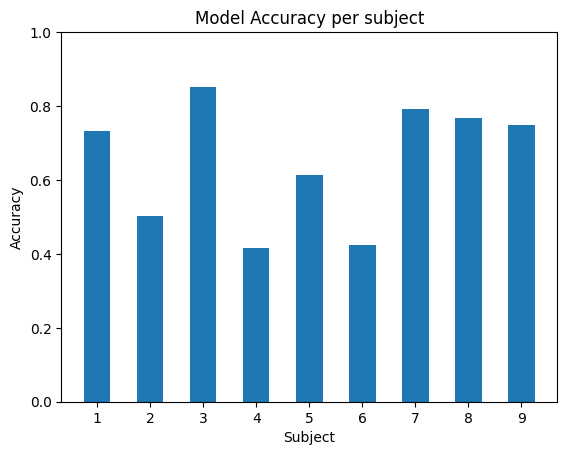

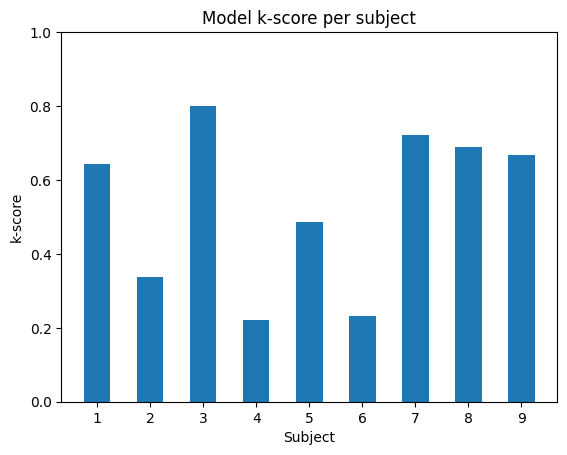

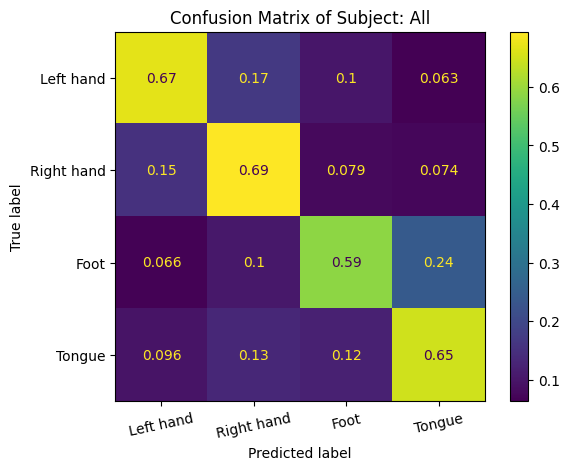

In [ ]:
train_conf['model']='ShallowConvNet'
train(dataset_conf,train_conf,results_path)
model=getModel(train_conf.get('model'),dataset_conf)
test(model,dataset_conf,results_path)

To run all models

In [ ]:
#model_names = ['ATCNet', 'EEGTCNet', 'EEGNet', 'DeepConvNet', 'ShallowConvNet']
#train_conf = {
#   'batch_size': 64,
#   'epochs': 500,
#    'patience': 100,
#    'lr': 0.001,
#    'n_train': 1,
#    'LearnCurves': True,
#   'from_logits': False,
#}
#
#for model_name in model_names:
#    train_conf['model'] = model_name
#    train(dataset_conf, train_conf, results_path)
#    model = getModel(train_conf.get('model'), dataset_conf)
#    test(model, dataset_conf, results_path)

In [ ]:
# prompt: code to zip and download the zip file colab "/content/Test-Predictions"

!zip -r /content/results.zip /content/results
from google.colab import files
files.download("/content/results.zip")